In [ ]:
# %%capture
# !pip install scipy statsmodels matplotlib seaborn matplotlib-venn nltk networkx pyvis

Link para vídeo: https://www.youtube.com/watch?v=xKbhL2E6kuI&ab_channel=GuiSales

In [82]:
import re
import pandas as pd
import numpy as np
from scipy import stats
import warnings
from statsmodels.stats.diagnostic import normal_ad
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from matplotlib_venn import venn3
import matplotlib.dates as mdates
import nltk
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams
from wordcloud import WordCloud
import networkx as nx
from pyvis.network import Network
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /home/guilherme-
[nltk_data]     sales/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### a) Ler o dataset fakeTelegram.BR_2022.csv

In [3]:
df = pd.read_csv('../Atividade 2/fakeTelegram.BR_2022.csv')

### b) Remova os trava-zaps.

In [4]:
len(df.index)

557586

In [5]:
df = df.loc[df['trava_zap'] == False]

In [6]:
len(df.index)

557570

### c) Remover as linhas repetidas (duplicadas).

In [7]:
df.drop_duplicates(inplace=True)

In [8]:
len(df.index)

557570

In [9]:
df_teste = df.drop_duplicates(subset=[col for col in df.columns if col != 'data_system' or col != 'date_message' or col!='text_content_anonymous'])
len(df_teste.index)

557570

### d) Remover textos com menos de 5 palavras.

In [10]:
df = df.loc[df['text_content_anonymous'].isna() == False]
df.reset_index(inplace=True, drop=True)

In [11]:
len(df.index)

444201

In [12]:
df.drop([i for i, s in enumerate(df['text_content_anonymous'].values.tolist()) if len(s.split()) < 5 ], inplace=True)

In [13]:
len(df.index)

339286

Adicionando coluna com quantidade de palavras

In [14]:
df['word_count'] = df['text_content_anonymous'].str.split().str.len()

### e) Para cada atributo numérico apresente:
	 	1. Medidas de Tendência Central
	 	2. Medidas de Variabilidade
	 	3. Tabela de Frequência e Histograma
	 	4. Boxplot
	 	5. QQ-Plot
	 	6. Teste de Normalidade
	 	7. Best Fit Distribution (usando diferentes métodos)

In [15]:
# Subitens 1 e 2
def centralidade_variabilidade(valores):
    valores = np.array(valores)
    valores = valores[np.isfinite(valores)]
    
    print("=== Medidas de Tendência Central ===")
    print(f"Média: {np.mean(valores):.4f}")
    print(f"Mediana: {np.median(valores):.4f}")
    moda = stats.mode(valores, keepdims=True)
    print(f"Moda: {moda.mode[0]} (Frequência: {moda.count[0]})")
    
    print("\n=== Medidas de Variabilidade ===")
    print(f"Amplitude: {np.ptp(valores):.4f}")
    print(f"Desvio Padrão: {np.std(valores, ddof=1):.4f}")
    print(f"Variância: {np.var(valores, ddof=1):.4f}")
    print(f"Coeficiente de Variação (CV): {100 * np.std(valores, ddof=1) / np.mean(valores):.2f}%")
    q75, q25 = np.percentile(valores, [75 ,25])
    print(f"IQR (Intervalo Interquartílico): {q75 - q25:.4f}")


In [ ]:
#Subitens 3, 4 e 5
def plotar_diagnosticos_distribuicao(valores, bins=10):
    valores = np.array(valores)
    valores = valores[np.isfinite(valores)]

    # === Tabela de Frequência ===
    print("=== Tabela de Frequência ===")
    contagem, intervalos = np.histogram(valores, bins=bins)
    porcentagens = 100 * contagem / contagem.sum()
    linhas = []

    for i in range(len(contagem)):
        linhas.append({
            'Intervalo': f"[{intervalos[i]:.2f}, {intervalos[i+1]:.2f})",
            'Frequência': contagem[i],
            'Percentual (%)': f"{porcentagens[i]:.2f}"
        })

    tabela = pd.DataFrame(linhas)
    print(tabela.to_string(index=False))

    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    # Boxplot
    axs[0].boxplot(valores, vert=True, patch_artist=True, boxprops=dict(facecolor='lightblue'))
    axs[0].set_title('Boxplot')
    axs[0].grid(True)

    # Q-Q Plot
    stats.probplot(valores, dist="norm", plot=axs[1])
    axs[1].get_lines()[1].set_color('red')
    axs[1].set_title('Q-Q Plot (Normal)')

    # Histograma com curva normal
    mu, sigma = np.mean(valores), np.std(valores, ddof=1)
    axs[2].hist(valores, bins=bins, density=True, alpha=0.6, color='skyblue', edgecolor='black')
    
    x = np.linspace(min(valores), max(valores), 1000)
    normal_pdf = stats.norm.pdf(x, mu, sigma)
    axs[2].plot(x, normal_pdf, 'r-', linewidth=2, label='Curva Normal')
    axs[2].set_title('Histograma com Curva Normal')
    axs[2].legend()
    axs[2].grid(True)

    plt.tight_layout()
    plt.show()


In [17]:
# Subitem 6
def normalidade(valores):
    valores = np.array(valores)
    valores = valores[np.isfinite(valores)]

    print("=== Testes de Normalidade ===")

    # Shapiro-Wilk
    stat_shapiro, p_shapiro = stats.shapiro(valores)
    print(f"Shapiro-Wilk: Estatística = {stat_shapiro:.4f}, p-valor = {p_shapiro:.4f} -> {'Normal' if p_shapiro > 0.05 else 'Não Normal'}")

    # Anderson-Darling
    stat_ad, p_value_ad = normal_ad(valores)
    print(f"Anderson-Darling: Estatística = {stat_ad:.4f}, p-valor = {p_value_ad:.4f} -> {'Normal' if p_value_ad > 0.05 else 'Não Normal'}")

    # Kolmogorov-Smirnov (ajustado com média e std da amostra)
    mu, sigma = np.mean(valores), np.std(valores, ddof=1)
    ks_stat, ks_p = stats.kstest(valores, 'norm', args=(mu, sigma))
    print(f"Kolmogorov-Smirnov: Estatística = {ks_stat:.4f}, p-valor = {ks_p:.4f} -> {'Normal' if ks_p > 0.05 else 'Não Normal'}")

In [18]:
#subitem 7
def best_fit_distribution(valores, verbose=True):
    valores = np.array(valores)
    valores = valores[np.isfinite(valores)]

    DISTRIBUICOES_TESTADAS = [
        stats.norm, stats.expon, stats.gamma, stats.beta,
        stats.lognorm, stats.weibull_min, stats.weibull_max,
        stats.uniform, stats.pareto
    ]

    resultados = []

    for dist in DISTRIBUICOES_TESTADAS:
        try:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")

                params = dist.fit(valores)

                log_likelihood = np.sum(dist.logpdf(valores, *params))

                k = len(params)

                aic = 2 * k - 2 * log_likelihood

                ks_stat, ks_p = stats.kstest(valores, dist.name, args=params)

                resultados.append({
                    "Distribuição": dist.name,
                    "Parâmetros": params,
                    "LogLik": log_likelihood,
                    "AIC": aic,
                    "KS_p": ks_p
                })
        except Exception as e:
            if verbose:
                print(f"[!] Erro ao ajustar {dist.name}: {e}")

    resultados_ordenados = sorted(resultados, key=lambda x: x["AIC"])

    if verbose:
        print("\n=== Distribuições ordenadas por melhor AIC ===")
        for r in resultados_ordenados[:5]:
            print(f"{r['Distribuição']:>15} | AIC: {r['AIC']:.2f} | KS-p: {r['KS_p']:.4f}")

    print("\nMelhor Ajuste:")
    print(f"Distribuição: {resultados_ordenados[0]['Distribuição']}")
    print(f"Parâmetros: {resultados_ordenados[0]['Parâmetros']}")




=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=- Nome da Coluna: score_sentiment =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-

=== Medidas de Tendência Central ===
Média: 0.0220
Mediana: 0.0000
Moda: 0.0 (Frequência: 77462)

=== Medidas de Variabilidade ===
Amplitude: 1.9992
Desvio Padrão: 0.5297
Variância: 0.2806
Coeficiente de Variação (CV): 2405.12%
IQR (Intervalo Interquartílico): 0.8871

=== Tabela de Frequência ===
     Intervalo  Frequência Percentual (%)
[-1.00, -0.80)       25624           7.55
[-0.80, -0.60)       28048           8.27
[-0.60, -0.40)       30398           8.96
[-0.40, -0.20)       25184           7.42
[-0.20, -0.00)       18458           5.44
 [-0.00, 0.20)       89774          26.46
  [0.20, 0.40)       22971           6.77
  [0.40, 0.60)       42844          12.63
  [0.60, 0.80)       26972           7.95
  [0.80, 1.00)       28966           8.54


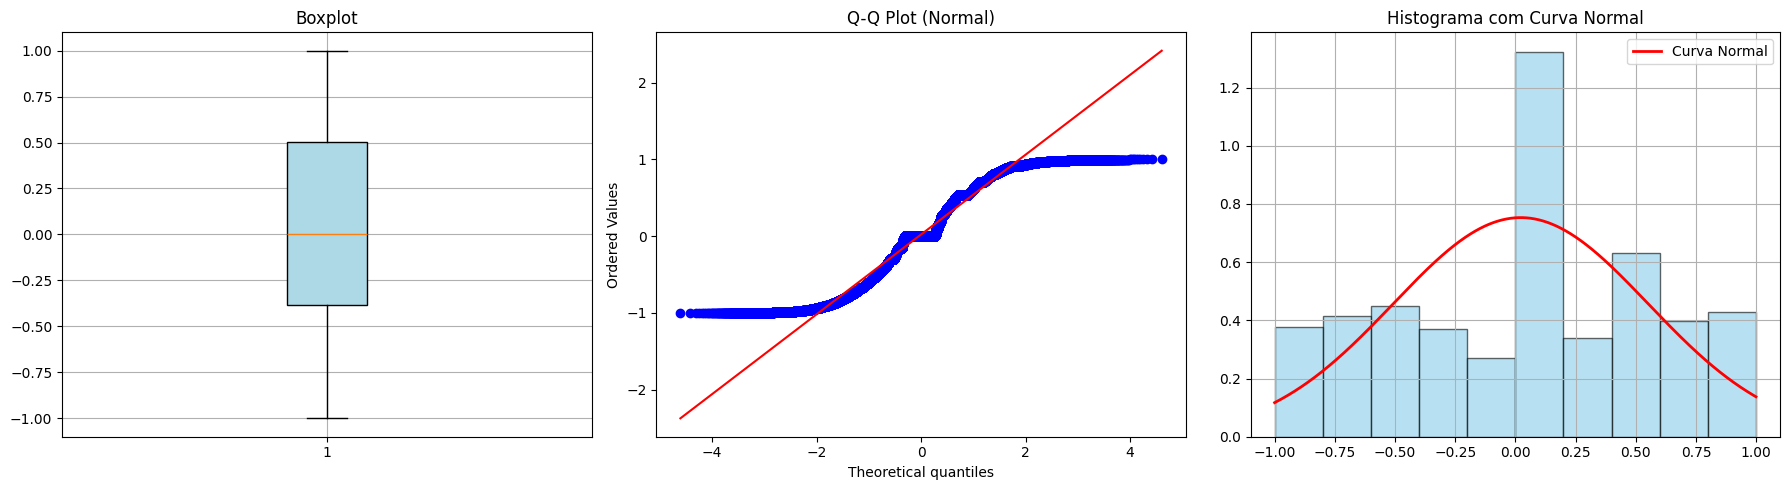


=== Testes de Normalidade ===
Shapiro-Wilk: Estatística = 0.9623, p-valor = 0.0000 -> Não Normal
Anderson-Darling: Estatística = 3890.3277, p-valor = 0.0000 -> Não Normal
Kolmogorov-Smirnov: Estatística = 0.1214, p-valor = 0.0000 -> Não Normal



/home/guilherme-sales/miniconda3/envs/ds_ufc/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 339239.
  res = hypotest_fun_out(*samples, **kwds)



=== Distribuições ordenadas por melhor AIC ===
           beta | AIC: 462511.35 | KS-p: 0.0000
        uniform | AIC: 470017.67 | KS-p: 0.0000
    weibull_max | AIC: 517688.58 | KS-p: 0.0000
    weibull_min | AIC: 521220.78 | KS-p: 0.0000
           norm | AIC: 531617.67 | KS-p: 0.0000

Melhor Ajuste:
Distribuição: beta
Parâmetros: (np.float64(1.225944158103615), np.float64(1.1806490456169234), np.float64(-1.0011048537697262), np.float64(2.000338468408864))


=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=- Nome da Coluna: score_misinformation =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-

=== Medidas de Tendência Central ===
Média: 0.3123
Mediana: 0.1976
Moda: 0.1106282729517939 (Frequência: 1019)

=== Medidas de Variabilidade ===
Amplitude: 1.0000
Desvio Padrão: 0.2937
Variância: 0.0863
Coeficiente de Variação (CV): 94.06%
IQR (Intervalo Interquartílico): 0.4119

=== Tabela de Frequência ===
   Intervalo  Frequência Percentual (%)
[0.00, 0.10)       51142 

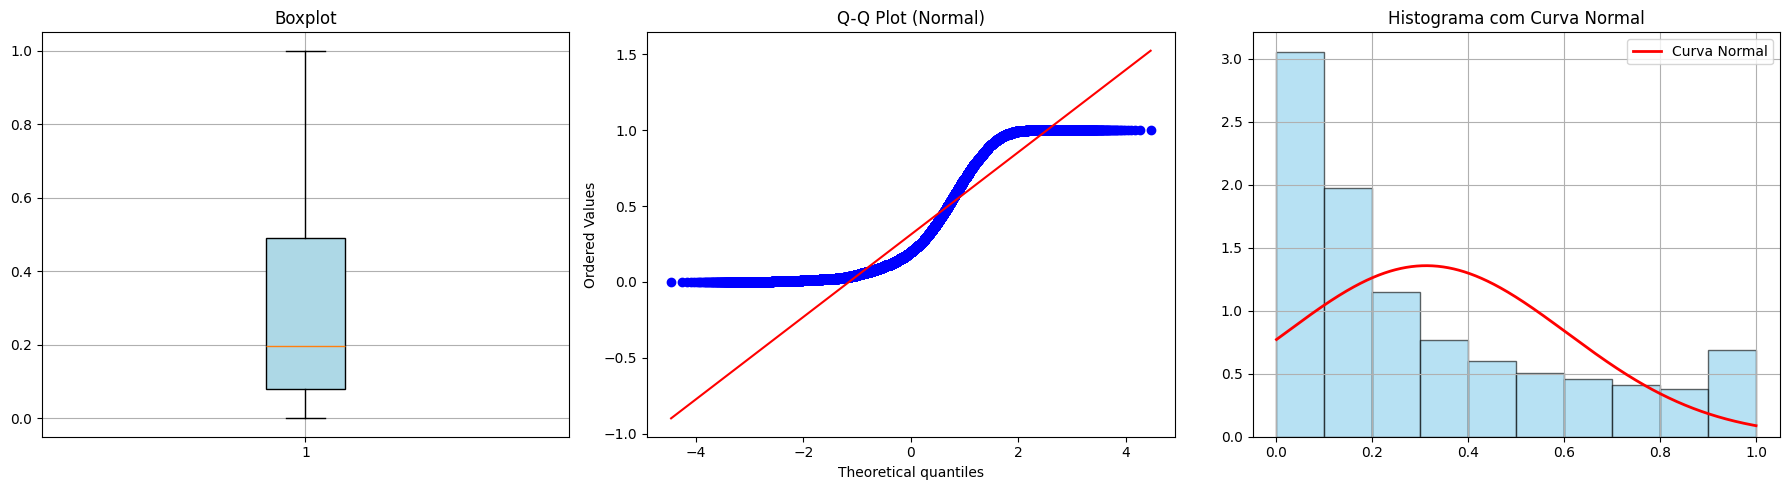


=== Testes de Normalidade ===
Shapiro-Wilk: Estatística = 0.8555, p-valor = 0.0000 -> Não Normal
Anderson-Darling: Estatística = 8500.4196, p-valor = 0.0000 -> Não Normal
Kolmogorov-Smirnov: Estatística = 0.1557, p-valor = 0.0000 -> Não Normal



/home/guilherme-sales/miniconda3/envs/ds_ufc/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 167224.
  res = hypotest_fun_out(*samples, **kwds)



=== Distribuições ordenadas por melhor AIC ===
           beta | AIC: -66695.83 | KS-p: 0.0000
          gamma | AIC: -55042.88 | KS-p: 0.0000
    weibull_min | AIC: -54932.64 | KS-p: 0.0000
          expon | AIC: -54818.93 | KS-p: 0.0000
         pareto | AIC: -54816.93 | KS-p: 0.0000

Melhor Ajuste:
Distribuição: beta
Parâmetros: (np.float64(0.5970920868525846), np.float64(1.1260199279122054), np.float64(3.2731487152999994e-06), np.float64(1.0062722644155957))


=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=- Nome da Coluna: word_count =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-

=== Medidas de Tendência Central ===
Média: 42.0278
Mediana: 20.0000
Moda: 15 (Frequência: 28896)

=== Medidas de Variabilidade ===
Amplitude: 1256.0000
Desvio Padrão: 74.0505
Variância: 5483.4797
Coeficiente de Variação (CV): 176.19%
IQR (Intervalo Interquartílico): 26.0000

=== Tabela de Frequência ===
         Intervalo  Frequência Percentual (%)
    [5.00, 130.60)      3208

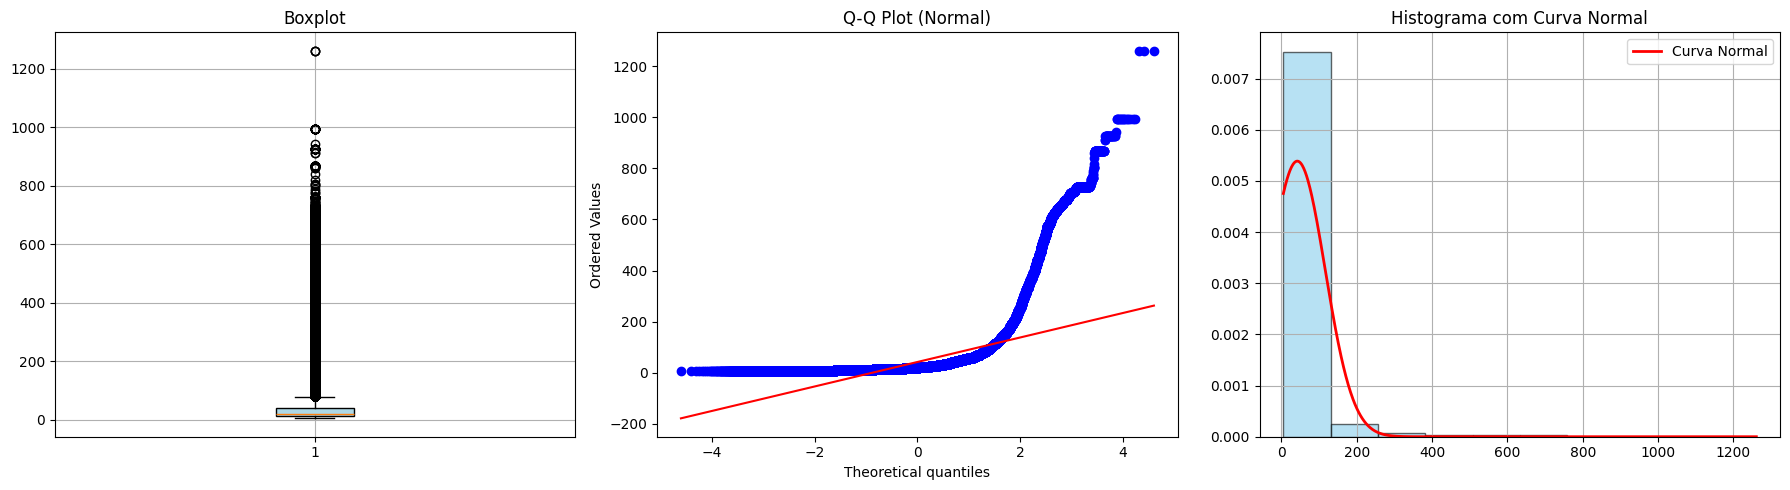


=== Testes de Normalidade ===
Shapiro-Wilk: Estatística = 0.4187, p-valor = 0.0000 -> Não Normal
Anderson-Darling: Estatística = inf, p-valor = 0.0000 -> Não Normal
Kolmogorov-Smirnov: Estatística = 0.3085, p-valor = 0.0000 -> Não Normal



/home/guilherme-sales/miniconda3/envs/ds_ufc/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 339286.
  res = hypotest_fun_out(*samples, **kwds)



=== Distribuições ordenadas por melhor AIC ===
    weibull_min | AIC: 2999338.66 | KS-p: 0.0000
        lognorm | AIC: 3007938.20 | KS-p: 0.0000
         pareto | AIC: 3024787.54 | KS-p: 0.0000
          gamma | AIC: 3040085.68 | KS-p: 0.0000
          expon | AIC: 3129353.76 | KS-p: 0.0000

Melhor Ajuste:
Distribuição: weibull_min
Parâmetros: (np.float64(0.7006481670386487), np.float64(4.999999999999999), np.float64(21.52892832137652))


In [20]:
for col in df.columns:
    if (df[col].dtype == 'float64' or df[col].dtype == 'int64') and not 'id' in col:
        print('\n')
        print('=-'*30, 'Nome da Coluna:', col, '=-'*30)
        vals = df[col].values.tolist()
        print()
        centralidade_variabilidade(vals)
        print()
        plotar_diagnosticos_distribuicao(vals)
        print()
        normalidade(vals)
        print()
        best_fit_distribution(vals)

### f) Para cada par de atributos numéricos apresente:
		1. O Coeficiente de Correlação apropriado
		2. Um Gráfico de Dispersão

In [21]:
def plot_correlacao_dispersao(df, x_col, y_col):

    # Remove valores não numéricos ou nulos
    dados = df[[x_col, y_col]].dropna()
    dados = dados[np.isfinite(dados[x_col]) & np.isfinite(dados[y_col])]

    # HEXBIN
    plt.figure(figsize=(8, 5))
    plt.hexbin(dados[x_col], dados[y_col], gridsize=30, cmap='Blues')
    plt.colorbar(label='Número de pontos')
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.title(f'Hexbin Plot: Densidade entre {x_col} e {y_col}')
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # HEATMAP DE CORRELAÇÃO
    corr = dados[[x_col, y_col]].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f'Correlação entre {x_col} e {y_col}')
    plt.tight_layout()
    plt.show()

    # SCATTER + REGRESSÃO
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x=x_col,
        y=y_col,
        data=dados,
        alpha=0.5,
        s=50,
        edgecolor=None
    )
    sns.regplot(
        x=x_col,
        y=y_col,
        data=dados,
        scatter=False,
        color='red',
        line_kws={'linewidth': 2}
    )
    plt.title(f'Relação entre {x_col} e {y_col}', fontsize=14)
    plt.xlabel(x_col, fontsize=12)
    plt.ylabel(y_col, fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()


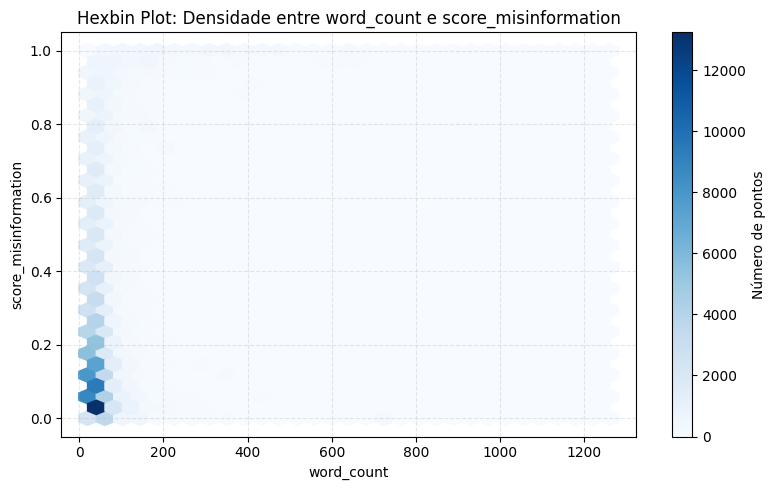

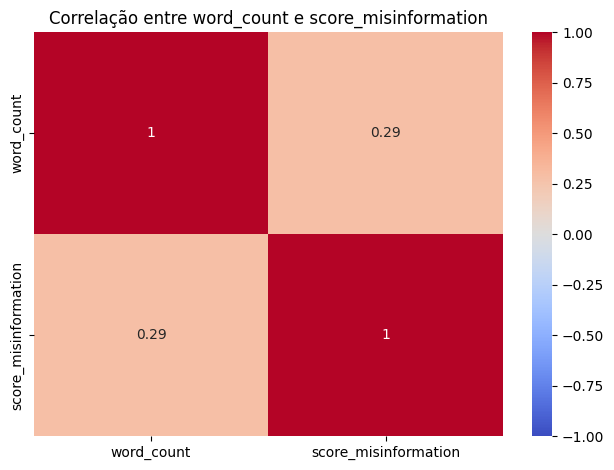

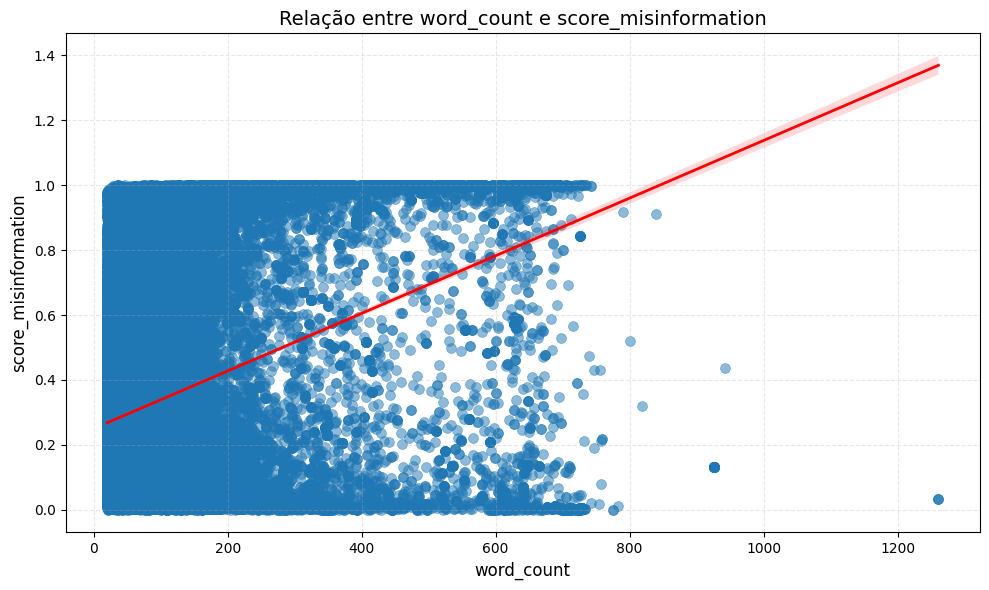

In [22]:
plot_correlacao_dispersao(df, 'word_count', 'score_misinformation')


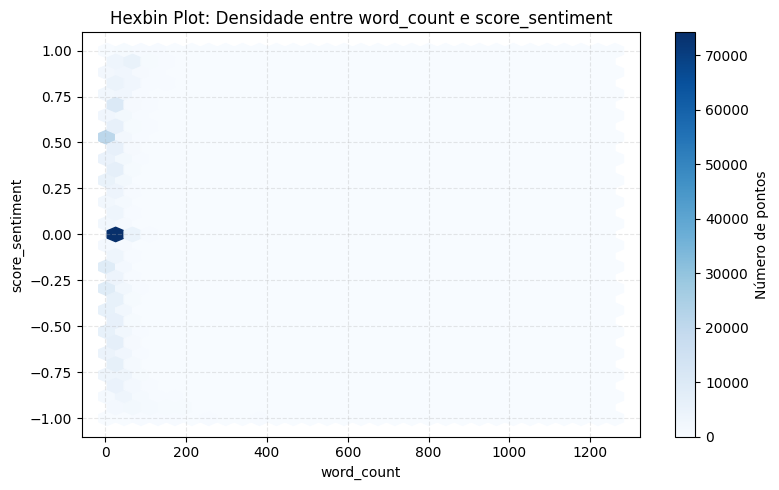

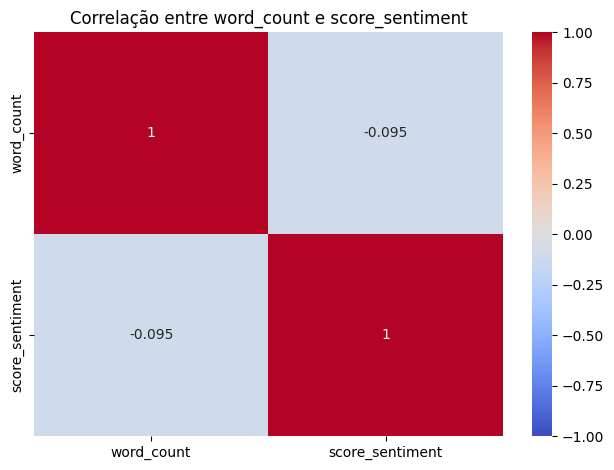

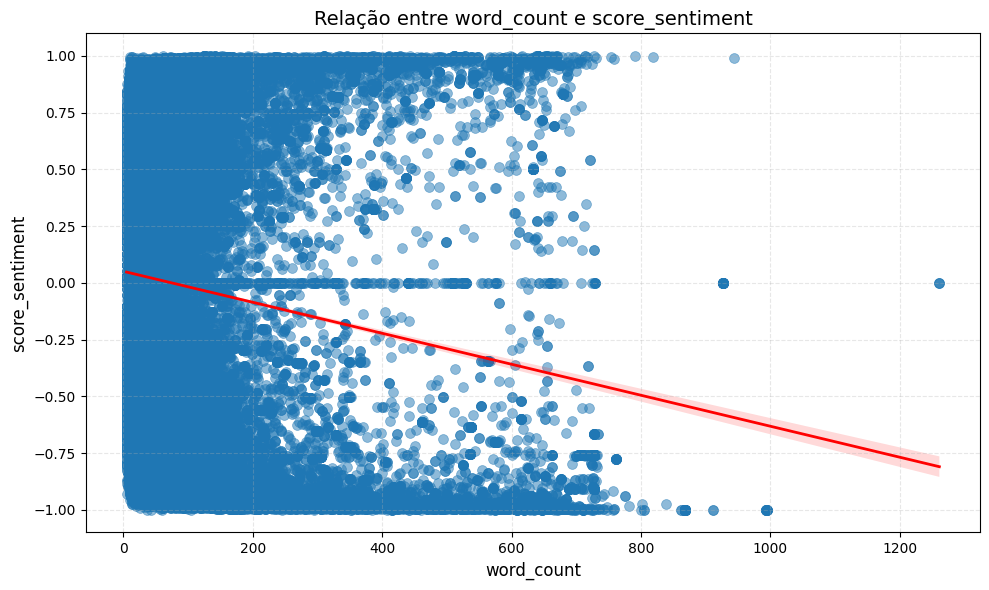

In [23]:
plot_correlacao_dispersao(df, 'word_count', 'score_sentiment')

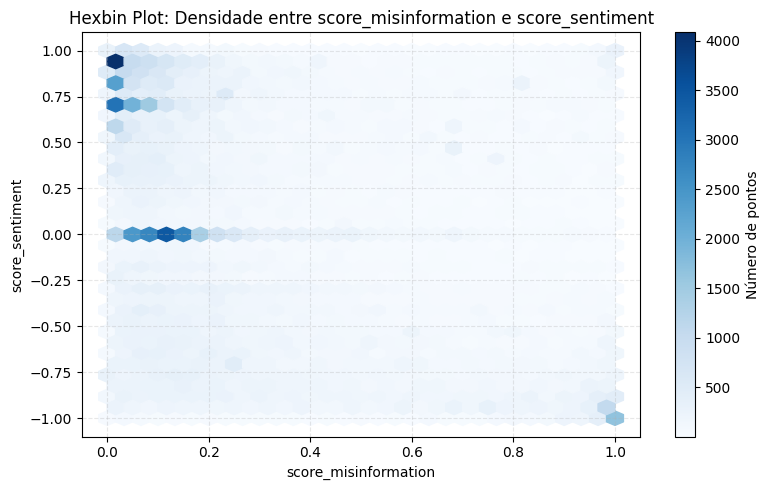

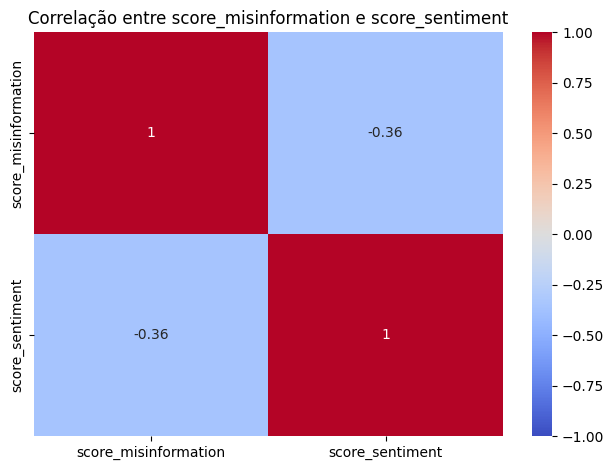

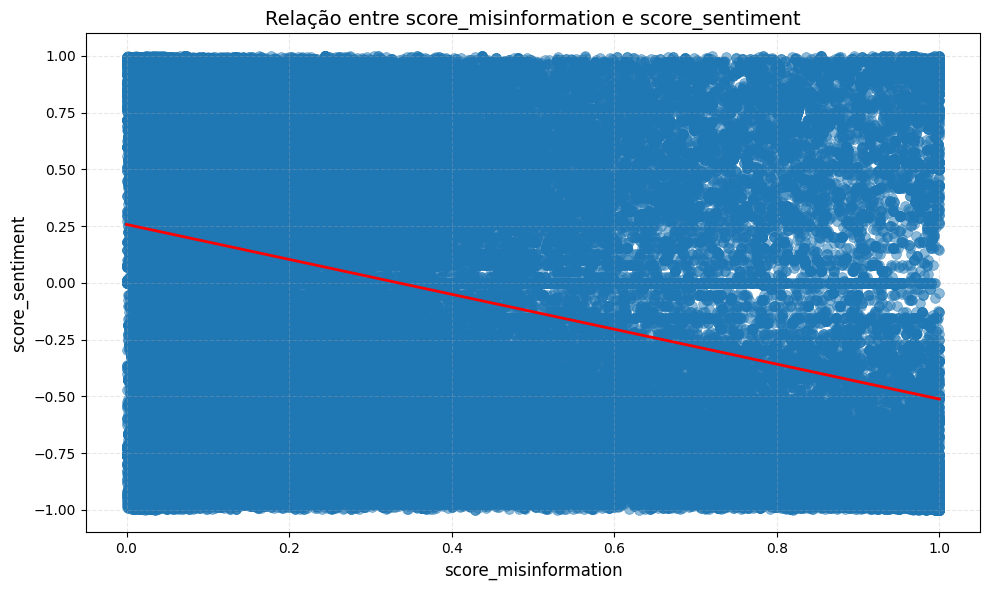

In [24]:
plot_correlacao_dispersao(df, 'score_misinformation', 'score_sentiment')

### g) Para cada par de atributos categóricos apresente

In [25]:
df_cat = df[['media_type', 'message_type', 'messenger', 'has_media']].fillna('no-media')

In [26]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    min_dim = min(confusion_matrix.shape) - 1
    return np.sqrt(chi2 / (n * min_dim)) if min_dim > 0 else 0.0

def matriz_cramers_v(df, categorias=None, annot=True):
    if categorias is None:
        categorias = df.select_dtypes(include=['object', 'category']).columns.tolist()
    
    matriz = pd.DataFrame(index=categorias, columns=categorias, dtype=float)

    for col1 in categorias:
        for col2 in categorias:
            if col1 == col2:
                matriz.loc[col1, col2] = 1.0
            else:
                matriz.loc[col1, col2] = cramers_v(df[col1], df[col2])

    plt.figure(figsize=(10, 8))
    sns.heatmap(matriz.astype(float), annot=annot, cmap="coolwarm", vmin=0, vmax=1)
    plt.title("Matriz de Cramér's V entre Variáveis Categóricas")
    plt.tight_layout()
    plt.show()
    
    return matriz


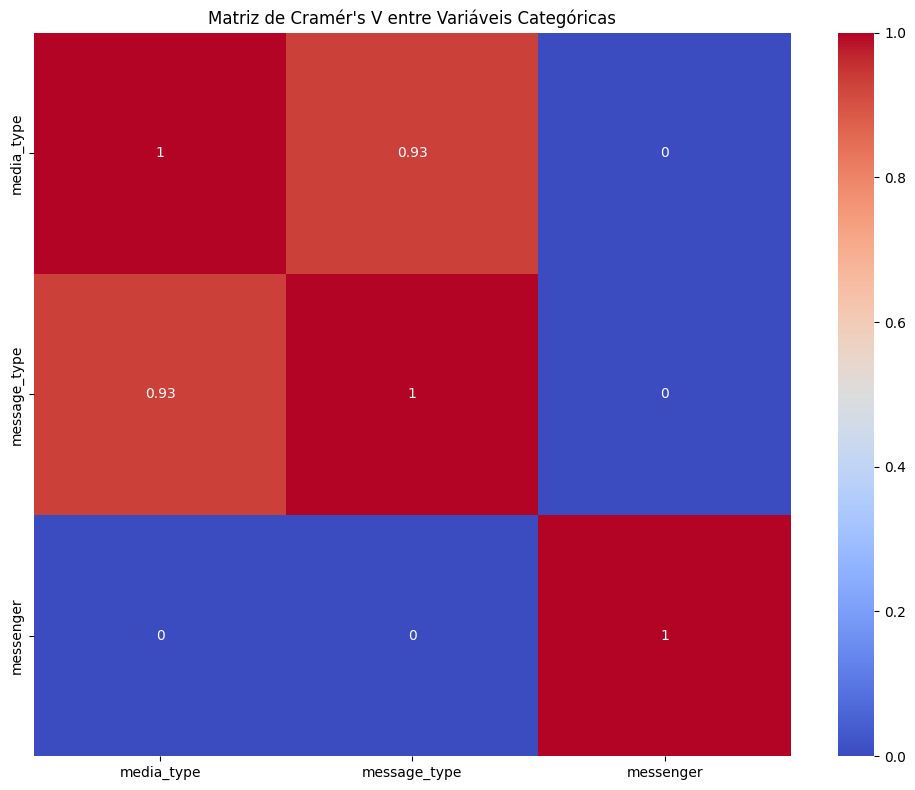

,media_type,message_type,messenger
media_type,1.000000,0.931516,0.0
message_type,0.931516,1.000000,0.0
messenger,0.000000,0.000000,1.0


In [27]:
matriz_cramers_v(df_cat)

### h) Crie uma visualização (gráfico) para apresentar:

1. As quantidades de grupos, usuários e mensagens;

In [28]:
grupos = df['id_group_anonymous'].dropna().drop_duplicates().tolist()
usuarios = df['id_member_anonymous'].dropna().drop_duplicates().tolist()
msgs = df['text_content_anonymous'].dropna().drop_duplicates().tolist()

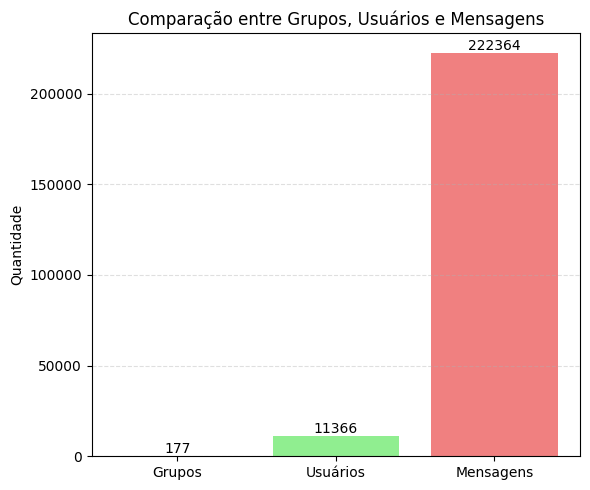

In [29]:
valores = [len(grupos), len(usuarios), len(msgs)]
categorias = ['Grupos', 'Usuários', 'Mensagens']

plt.figure(figsize=(6, 5))
plt.bar(categorias, valores, color=['skyblue', 'lightgreen', 'lightcoral'])
plt.ylabel('Quantidade')
plt.title('Comparação entre Grupos, Usuários e Mensagens')
plt.grid(axis='y', linestyle='--', alpha=0.4)
for i, v in enumerate(valores):
    plt.text(i, v + 1, str(v), ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

2. A quantidade de mensagens que possuem apenas texto X mídia;

In [30]:
df['message_type'].value_counts()

message_type
Texto          212855
Imagem          79181
Url             40625
Video            3798
Application      2802
Audio              22
Image               2
Text                1
Name: count, dtype: int64

In [31]:
texts = 0
medias = 0

for cat, val in df['message_type'].value_counts().items():
	if 'Text' in cat:
		texts += val
	else:
		medias += val

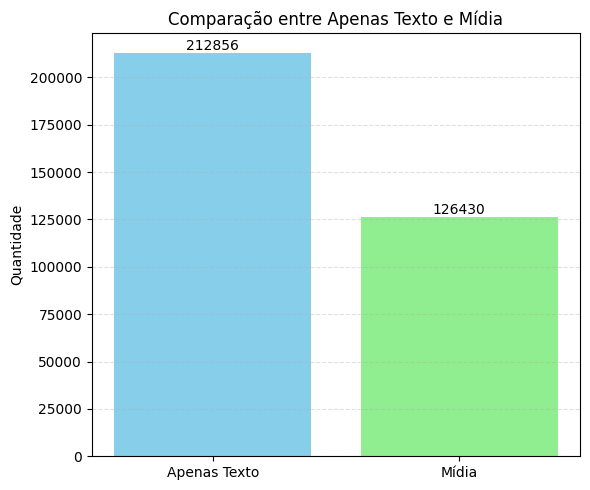

In [32]:
valores = [texts, medias]
categorias = ['Apenas Texto', 'Mídia']

plt.figure(figsize=(6, 5))
plt.bar(categorias, valores, color=['skyblue', 'lightgreen'])
plt.ylabel('Quantidade')
plt.title('Comparação entre Apenas Texto e Mídia')
plt.grid(axis='y', linestyle='--', alpha=0.4)
for i, v in enumerate(valores):
    plt.text(i, v + 1, str(v), ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

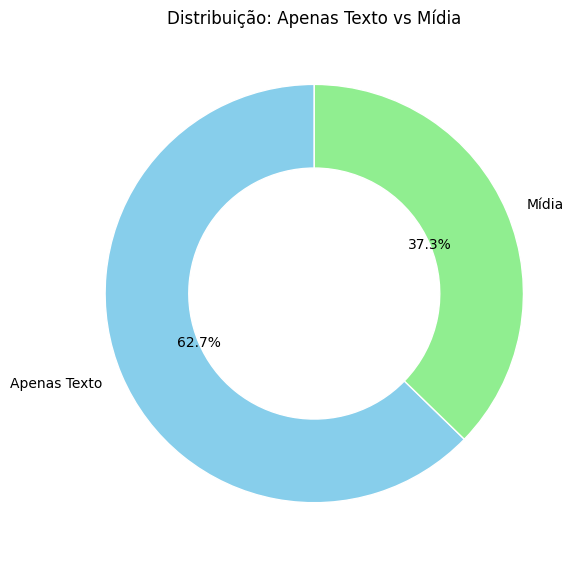

In [33]:
# Valores e categorias
valores = [texts, medias]
categorias = ['Apenas Texto', 'Mídia']

# Cores
cores = ['skyblue', 'lightgreen']

# Gráfico
plt.figure(figsize=(6, 6))
plt.pie(
    valores,
    labels=categorias,
    colors=cores,
    autopct='%1.1f%%',
    startangle=90,
    wedgeprops={'width': 0.4, 'edgecolor': 'white'}
)

plt.title('Distribuição: Apenas Texto vs Mídia')
plt.tight_layout()
plt.show()


3. Quantidade de mensagens por tipo de mídia (jpg, mp4 etc);

In [34]:
result = {}

for _, media_type in df.media_type.dropna().items():
    if media_type in result.keys():
        result[media_type] += 1
    else:
        result[media_type] = 1

In [35]:
len(result.keys())

41

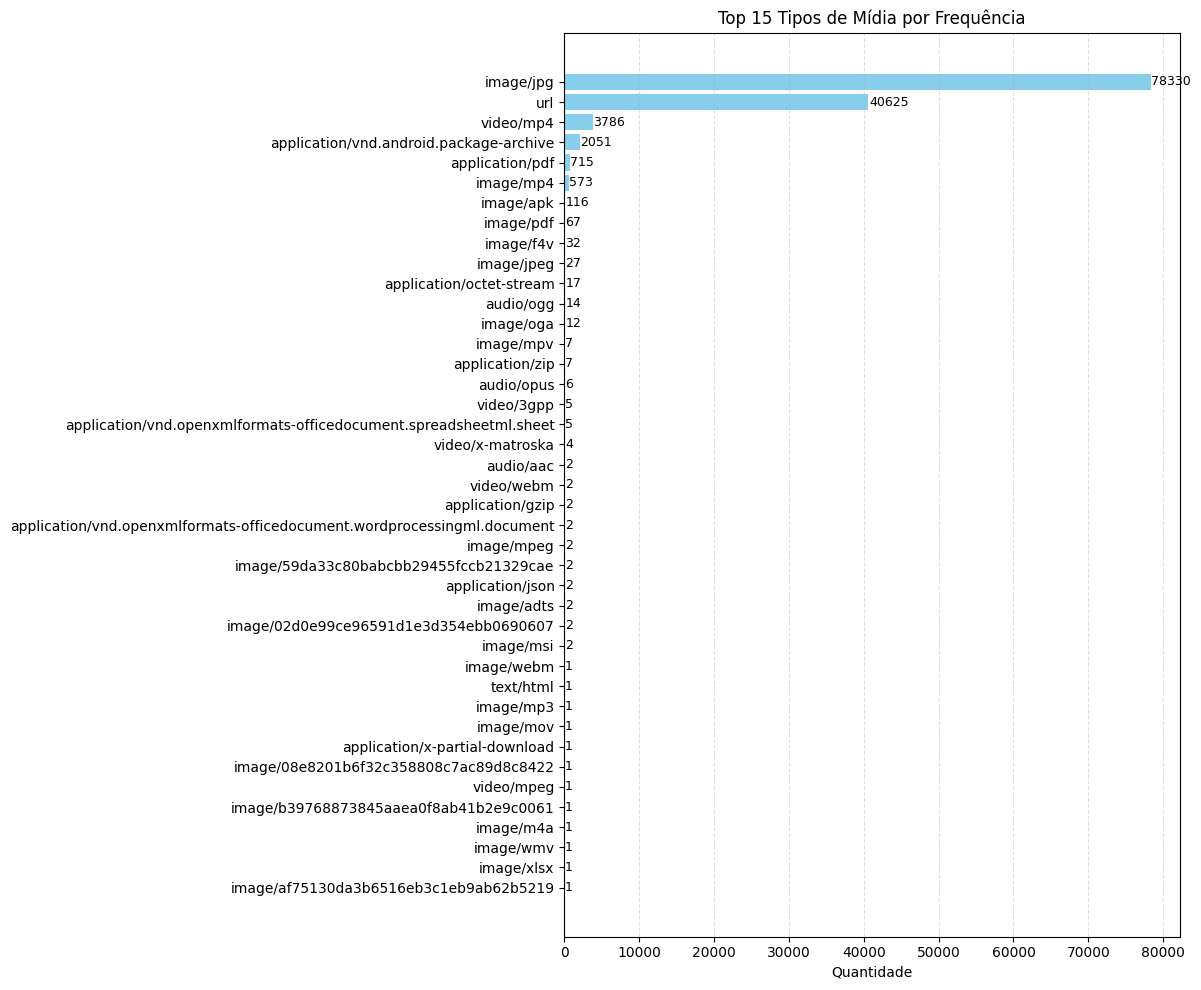

In [36]:
df_midia = pd.DataFrame(list(result.items()), columns=['tipo', 'quantidade'])
df_midia = df_midia.sort_values(by='quantidade', ascending=False).head(41)

# Plotar
plt.figure(figsize=(12, 10))
plt.barh(df_midia['tipo'], df_midia['quantidade'], color='skyblue')
plt.xlabel('Quantidade')
plt.title('Top 15 Tipos de Mídia por Frequência')
plt.gca().invert_yaxis()  
plt.grid(axis='x', linestyle='--', alpha=0.4)

# Mostrar valores nas barras
for i, v in enumerate(df_midia['quantidade']):
    plt.text(v + 100, i, str(v), va='center', fontsize=9)

plt.tight_layout()
plt.show()

4. A relação entre a quantidade de mensagens e a quantidade de palavras presente nas mensagens;

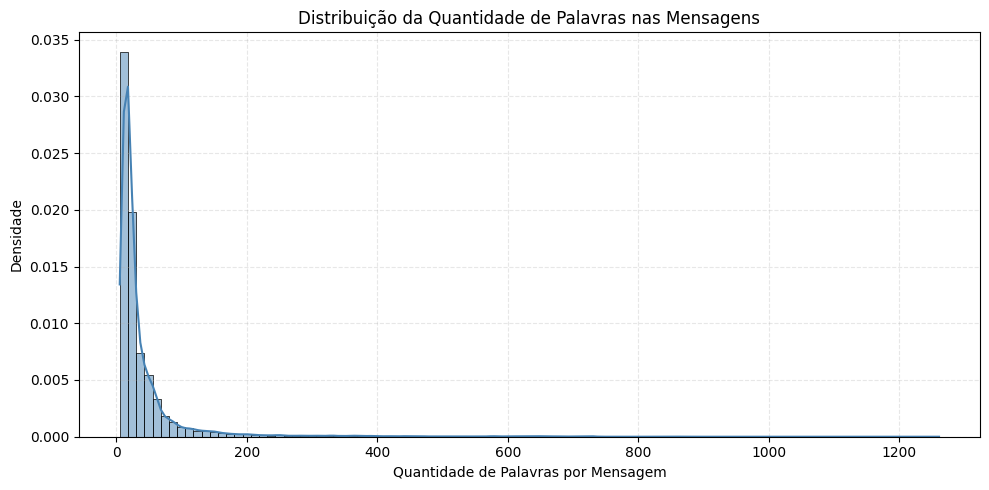

In [37]:
plt.figure(figsize=(10, 5))
sns.histplot(df['word_count'], kde=True, stat='density', bins=100, color='steelblue')
plt.xlabel('Quantidade de Palavras por Mensagem')
plt.ylabel('Densidade')
plt.title('Distribuição da Quantidade de Palavras nas Mensagens')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

5 ~ 9 Inválidas

10. As 30 URLs que mais se repetem (mais compartilhadas);

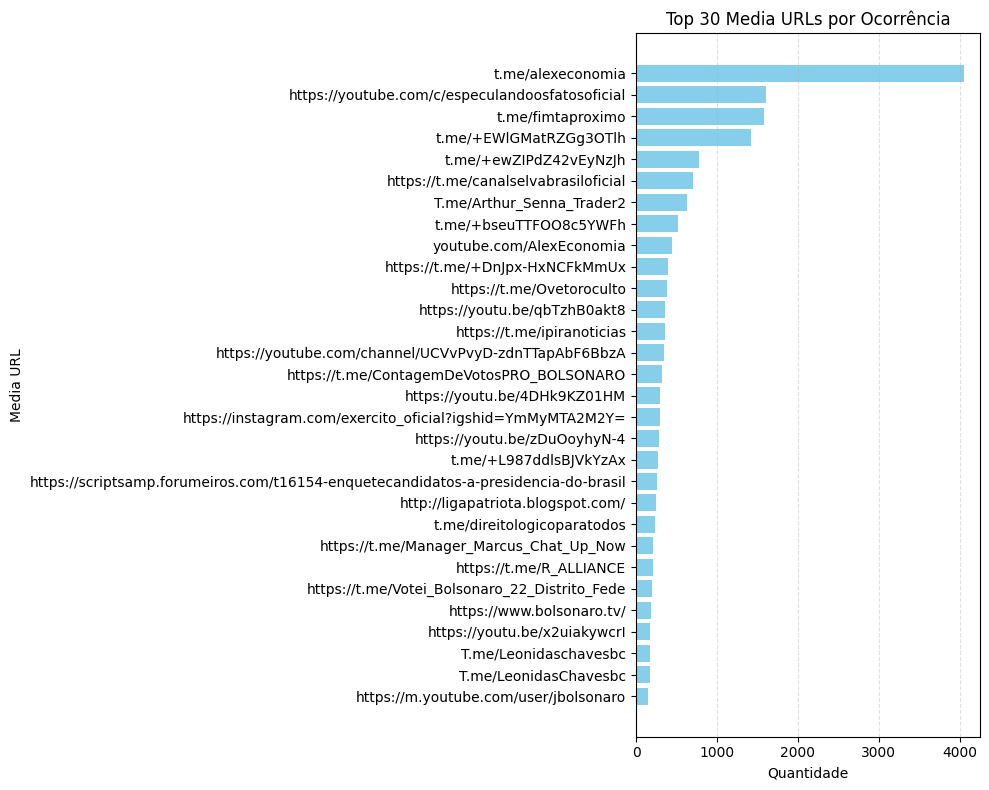

In [38]:
top_urls = (
    df[df['media_url'].notna()]
    .groupby('media_url')
    .size()
    .reset_index(name='qtde_url')
    .sort_values(by='qtde_url', ascending=False)
    .head(30)
)

# 2. Plotagem
plt.figure(figsize=(10, 8))
plt.barh(top_urls['media_url'], top_urls['qtde_url'], color='skyblue')
plt.xlabel('Quantidade')
plt.ylabel('Media URL')
plt.title('Top 30 Media URLs por Ocorrência')
plt.gca().invert_yaxis()  # Coloca o maior no topo
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

11. Os 30 domínios que mais se repetem (mais compartilhados);

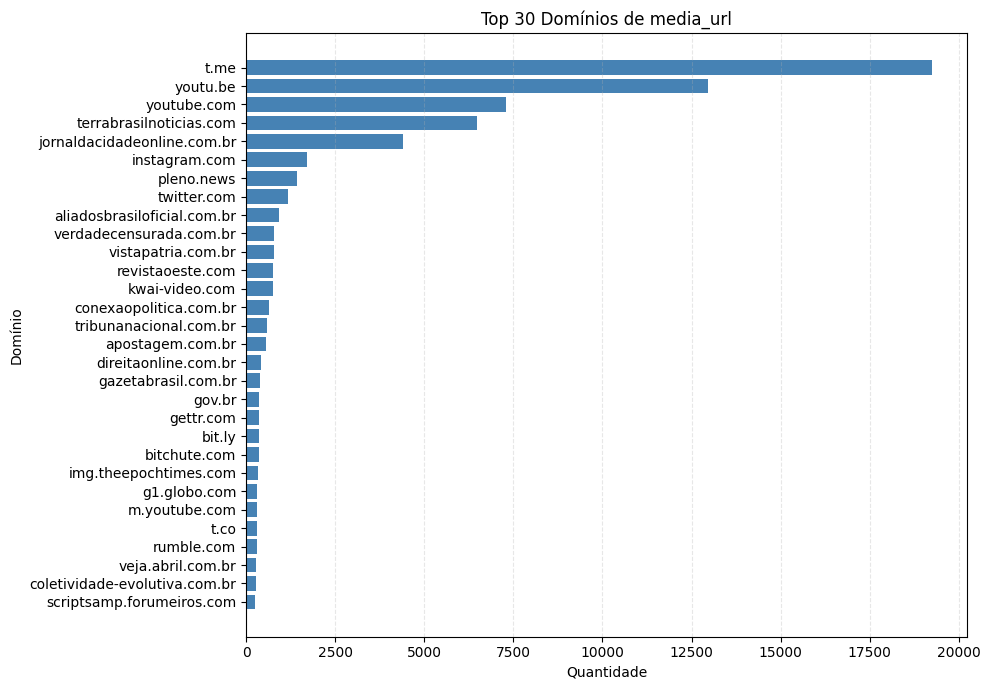

In [39]:
df_filtrado = df[df['media_url'].notna()].copy()

#Extrai domínio com regex e lowercase
df_filtrado['dominio'] = df_filtrado['media_url'].str.extract(r'^(?:https?://)?(?:www\.)?([^/]+)')[0].str.lower()

# Conta por domínio
top_dominios = (
    df_filtrado.groupby('dominio')
    .size()
    .reset_index(name='total')
    .sort_values(by='total', ascending=False)
    .head(30)
)

# Plotagem
plt.figure(figsize=(10, 7))
plt.barh(top_dominios['dominio'], top_dominios['total'], color='steelblue')
plt.xlabel('Quantidade')
plt.ylabel('Domínio')
plt.title('Top 30 Domínios de media_url')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

12. Os 30 usuários mais ativos;

In [40]:
top_usuarios = (
    df[df['id_member_anonymous'].notna() & (df['text_content_anonymous'].notna() | df['media'].notna())]
    .groupby('id_member_anonymous')
    .size()
    .reset_index(name='count_atividade')
    .rename(columns={'id_member_anonymous': 'users'})
    .sort_values(by='count_atividade', ascending=False)
    .head(30)
)

top_usuarios 

,users,count_atividade
7616,abe534d581ec6d552243d6955d3c3cd8,12289
998,1665e22b0f564cd46d343f7677014821,5452
1191,1ac091b8ed5c4e42383f1b4ff4cc9b2d,3260
8820,c743967449a387ad2c1c7e03b2c45b36,3017
9420,d49f81df0c75d1d72bee6c5b2d707da0,1571
10745,f233cf8b1d4ede06f32199a7e0081bf5,1088
10363,e8fd8fee8c39342d37993775da7756d5,1027
10307,e7998863ac2a40086657fab4a6b463c9,921
8533,c052c859b42c5a1923c22f5a201de746,831
11114,fa582c9e95da255e44f4c198d0daf3df,817


13. Relação entre quantidade de mensagens contendo somente texto e mensagens contendo mídia dos usuários mais ativos.

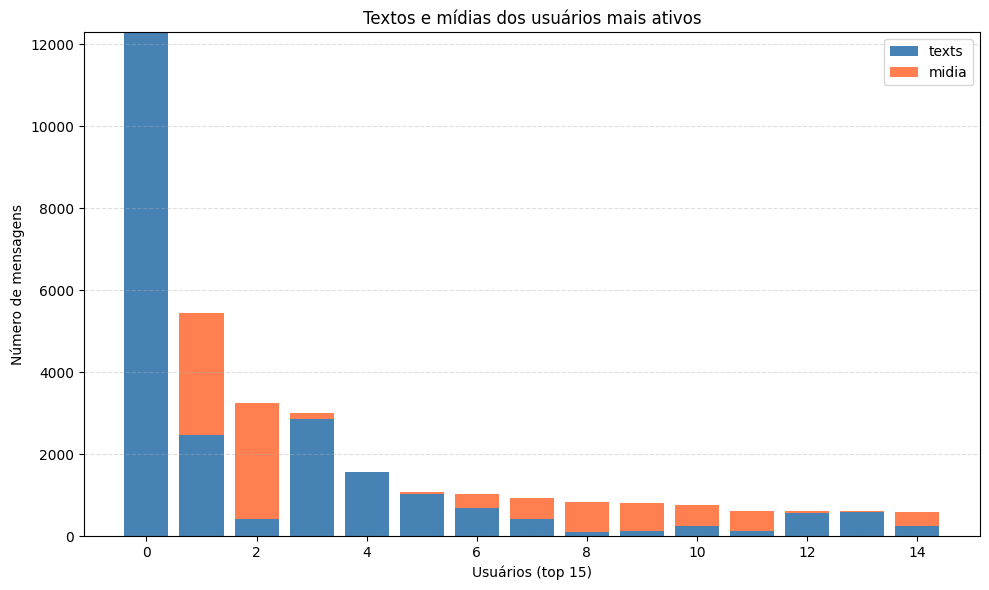

In [41]:
# Filtrar mensagens com texto ou mídia
df_filtrado = df[df['id_member_anonymous'].notna() & (df['text_content_anonymous'].notna() | df['media'].notna())]

# Separar textos e mídias
df_texts = df_filtrado[df_filtrado['media'].isna()]
df_midia = df_filtrado[df_filtrado['media'].notna()]

# Contar por usuário
contagem_textos = df_texts.groupby('id_member_anonymous').size().reset_index(name='texts')
contagem_midia = df_midia.groupby('id_member_anonymous').size().reset_index(name='midia')

# Juntar as contagens
df_contagem = pd.merge(contagem_textos, contagem_midia, how='outer', on='id_member_anonymous').fillna(0)

# Calcular total e pegar os mais ativos
df_contagem['total'] = df_contagem['texts'] + df_contagem['midia']
top_usuarios = df_contagem.sort_values(by='total', ascending=False).head(15).reset_index(drop=True)

# Plotar
plt.figure(figsize=(10, 6))
plt.bar(top_usuarios.index, top_usuarios['texts'], label='texts', color='steelblue')
plt.bar(top_usuarios.index, top_usuarios['midia'], bottom=top_usuarios['texts'], label='midia', color='coral')

plt.title('Textos e mídias dos usuários mais ativos')
plt.xlabel('Usuários (top 15)')
plt.ylabel('Número de mensagens')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

14. Os 30 usuários que mais compartilharam texto;

In [42]:
top_text_users = (
    df[df['id_member_anonymous'].notna()]
    .groupby('id_member_anonymous')['text_content_anonymous']
    .count()
    .reset_index(name='count_messages')
    .rename(columns={'id_member_anonymous': 'users'})
    .sort_values(by='count_messages', ascending=False)
    .head(30)
)

top_text_users  


,users,count_messages
7616,abe534d581ec6d552243d6955d3c3cd8,12289
998,1665e22b0f564cd46d343f7677014821,5452
1191,1ac091b8ed5c4e42383f1b4ff4cc9b2d,3260
8820,c743967449a387ad2c1c7e03b2c45b36,3017
9420,d49f81df0c75d1d72bee6c5b2d707da0,1571
10745,f233cf8b1d4ede06f32199a7e0081bf5,1088
10363,e8fd8fee8c39342d37993775da7756d5,1027
10307,e7998863ac2a40086657fab4a6b463c9,921
8533,c052c859b42c5a1923c22f5a201de746,831
11114,fa582c9e95da255e44f4c198d0daf3df,817


15. Os 30 usuários que mais compartilharam mídias;

In [43]:
top_media_users = (
    df[(df['has_media'] == True) & df['id_member_anonymous'].notna()]
    .groupby('id_member_anonymous')
    .size()
    .reset_index(name='count_midia')
    .rename(columns={'id_member_anonymous': 'users'})
    .sort_values(by='count_midia', ascending=False)
    .head(30)
)

top_media_users


,users,count_midia
277,1665e22b0f564cd46d343f7677014821,2972
327,1ac091b8ed5c4e42383f1b4ff4cc9b2d,2843
2366,c052c859b42c5a1923c22f5a201de746,736
3068,fa582c9e95da255e44f4c198d0daf3df,701
1475,773b9bd5b02a2e96f9d732c29bfcb663,521
1082,56b8359fd127312651b80b8ed8030085,501
2840,e7998863ac2a40086657fab4a6b463c9,493
1047,53e74af95497f943c524abaaa9482e33,460
1856,9794a13f91433216821ad18624372498,458
1154,5d321b03e74b751ac577ef022350306d,449


16. As 30 mensagens mais compartilhadas;

In [44]:
def normalize_text(text):
    if pd.isna(text):
        return ''
    
    text = text.lower()
    text = re.sub(r'[áàãâä]', 'a', text)
    text = re.sub(r'[éèêë]', 'e', text)
    text = re.sub(r'[íìîï]', 'i', text)
    text = re.sub(r'[óòõôö]', 'o', text)
    text = re.sub(r'[úùûü]', 'u', text)
    text = re.sub(r'[ç]', 'c', text)
    text = re.sub(r'[^a-z0-9 ]', '', text)         # remove especiais
    text = re.sub(r'\s+', ' ', text)               # múltiplos espaços
    text = re.sub(r'\b(\w+)( \1\b)+', r'\1', text) # remove palavras com letras repetidas
    return text.strip()


In [45]:
df_textos = df[df['text_content_anonymous'].notna()].copy()
df_textos['normalized_text'] = df_textos['text_content_anonymous'].apply(normalize_text)

top_msns = (
    df_textos.groupby('normalized_text')
    .size()
    .reset_index(name='total')
    .sort_values(by='total', ascending=False)
    .head(30)
)

top_msns

,normalized_text,total
186931,this community was blocked in brazil following...,17422
204026,vpn taqiqlangan saytlardan bu vpn orqali ozbek...,1019
14870,amerikalik ayolni arab erkaklari tomonidan zor...,632
204186,we had no choice but to remain in the shadows ...,480
90433,httpstmecanalselvabrasiloficialselva brasil of...,467
50691,e conhecereis a verdade e a verdade vos libert...,450
0,,436
635,14 vpn watch sex with a 14yearold girl on porn...,400
25277,bem vindoa ao grupo ipira noticias compartilhe...,358
96180,inscreva se no canal tmefimtaproximo,232


17. As 30 mensagens mais compartilhadas em grupos diferentes;

In [46]:
# Filtrar mensagens com grupo e texto
df_filtrado = df[
    df['text_content_anonymous'].notna() &
    df['id_group_anonymous'].notna()
].copy()

# Normalizar texto
df_filtrado['normalized_text'] = df_filtrado['text_content_anonymous'].apply(normalize_text)

# Remover vazios
df_filtrado = df_filtrado[df_filtrado['normalized_text'].str.len() > 0]

# Contar grupos únicos por mensagem
top_msgs_grupos = (
    df_filtrado.groupby('normalized_text')['id_group_anonymous']
    .nunique()
    .reset_index(name='total_grupos')
    .sort_values(by='total_grupos', ascending=False)
    .head(30)
)

top_msgs_grupos

,normalized_text,total_grupos
186930,this community was blocked in brazil following...,59
25880,boa noite a todos o que eu vou dizer e serio a...,36
88286,hoje as 18 horas no canal inteligencia ltda do...,35
22512,atencao chamada urgente patriotas do brasil di...,31
144486,os ptistas nao quer que agente mostre que voto...,29
12179,ajudem a subir a janonesamigodepedofilopor favor,29
44861,de nada ira adiantar fiscalizar as urnas se na...,29
32586,brasileiros pior de que voces perderem seus co...,28
143869,os eleitores que ja enviou nao precisa mais en...,28
103356,lancaram o lulaflix uma coletanea com o que de...,27


18. Mensagens idênticas compartilhadas pelo mesmo usuário (e suas quantidades);

In [47]:
df_filtrado = df[
    df['text_content_anonymous'].notna() &
    df['id_member_anonymous'].notna()
].copy()

df_filtrado['normalized_text'] = df_filtrado['text_content_anonymous'].apply(normalize_text)

df_filtrado = df_filtrado[df_filtrado['normalized_text'].str.len() > 0]

repeticoes = (
    df_filtrado.groupby(['id_member_anonymous', 'normalized_text'])
    .size()
    .reset_index(name='total_repeticoes')
)

repeticoes = repeticoes[repeticoes['total_repeticoes'] > 1]
repeticoes = repeticoes.sort_values(by='total_repeticoes', ascending=False)

repeticoes 

,id_member_anonymous,normalized_text,total_repeticoes
104572,f233cf8b1d4ede06f32199a7e0081bf5,this community was blocked in brazil following...,838
86855,c743967449a387ad2c1c7e03b2c45b36,this community was blocked in brazil following...,532
45166,7696d5103cdb8ac352d748a1db1126b0,this community was blocked in brazil following...,530
7251,1665e22b0f564cd46d343f7677014821,bem vindoa ao grupo ipira noticias compartilhe...,357
61051,a398999c55f8d6f0c65760522ae12e45,this community was blocked in brazil following...,308
...,...,...,...
22805,31f49a13b6ea413aab34aa1e885a65b9,urgente indignado general heleno se manifesta ...,2
22883,32783be6c9de86a5b268719d4a151a93,contra tudo e contra todos tivemos no 1 turno ...,2
22885,32783be6c9de86a5b268719d4a151a93,em pdf httpsbitly3azpwzh para ouvir httpsbitly...,2
22951,32783be6c9de86a5b268719d4a151a93,vestir com modestia com muito pudor olhai como...,2


19. Mensagens idênticas compartilhadas pelo mesmo usuário em grupos distintos (e suas quantidades)

In [48]:
df_filtrado = df[
    df['text_content_anonymous'].notna() &
    df['id_member_anonymous'].notna() &
    df['id_group_anonymous'].notna()
].copy()
df_filtrado['normalized_text'] = df_filtrado['text_content_anonymous'].apply(normalize_text)
df_filtrado = df_filtrado[df_filtrado['normalized_text'].str.len() > 0]
mensagens_multigrupos = (
    df_filtrado.groupby(['id_member_anonymous', 'normalized_text'])['id_group_anonymous']
    .nunique()
    .reset_index(name='total_grupos')
)
mensagens_multigrupos = mensagens_multigrupos[mensagens_multigrupos['total_grupos'] > 1]
mensagens_multigrupos = mensagens_multigrupos.sort_values(by='total_grupos', ascending=False)
mensagens_multigrupos

,id_member_anonymous,normalized_text,total_grupos
62022,a7840e7844020149e197272748965862,alertaesse grupo foi criado pela esquerda com ...,16
22869,326d0a2f1bc5a1ede446fcf5dc31ff2e,urgentissimo esse grupo e uma fraude saiam des...,14
22864,326d0a2f1bc5a1ede446fcf5dc31ff2e,bomba bombavcs estao achando que irao consegui...,12
19572,29dda76df3384c28a07e8bad1ee9ceed,boa noite a todos o que eu vou dizer e serio a...,11
31174,4e93f1d3c83fd6041314517363b14ed5,pessoal nao envie seus comprovantes de votacao...,10
...,...,...,...
41,0049ead7ba0fe5920ee42c7ac245e073,creio que a propria esquerda esta fazendo esse...,2
31,0049ead7ba0fe5920ee42c7ac245e073,ao vivo multidao em igreja apoia bolsonaro pre...,2
24,0049ead7ba0fe5920ee42c7ac245e073,a midia militantes esta ressuscitando video an...,2
22,0036df952bd1bbdd86f79233aff6b6f3,lista de grupos telegramparalisacaoentrem no s...,2


20. Os 30 unigramas, bigramas e trigramas mais compartilhados (após a remoção de stop words);

In [49]:
nltk.download('stopwords')
stop_words = set(stopwords.words('portuguese')) | set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/guilherme-
[nltk_data]     sales/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


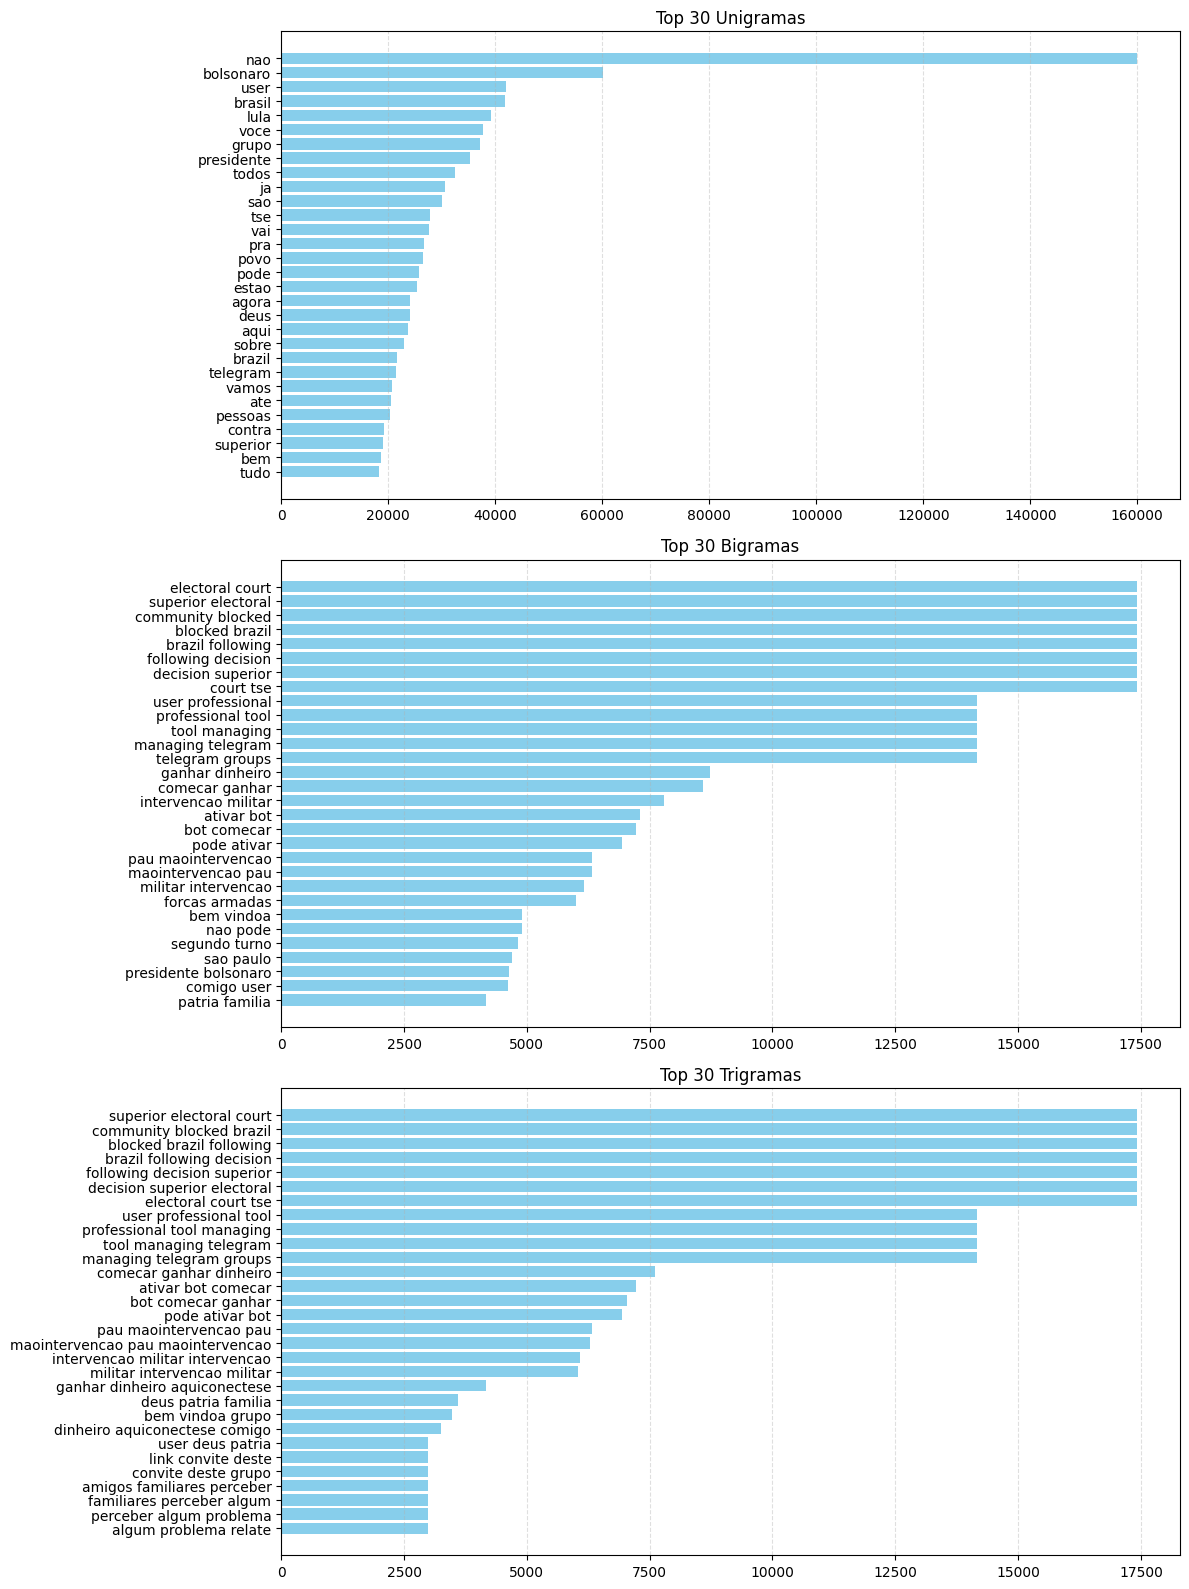

In [50]:
df_filtrado = df[df['text_content_anonymous'].notna()].copy()
df_filtrado['normalized'] = df_filtrado['text_content_anonymous'].apply(normalize_text)

all_tokens = []
bigrams_list = []
trigrams_list = []

for texto in df_filtrado['normalized']:
    tokens = [t for t in texto.split() if t not in stop_words]
    all_tokens.extend(tokens)
    bigrams_list.extend([' '.join(b) for b in ngrams(tokens, 2)])
    trigrams_list.extend([' '.join(t) for t in ngrams(tokens, 3)])

top_unigrams = Counter(all_tokens).most_common(30)
top_bigrams = Counter(bigrams_list).most_common(30)
top_trigrams = Counter(trigrams_list).most_common(30)

fig, axs = plt.subplots(3, 1, figsize=(12, 16))

def plot_ngram(ax, data, title):
    labels, values = zip(*data)
    ax.barh(labels, values, color='skyblue')
    ax.set_title(title)
    ax.invert_yaxis()
    ax.grid(axis='x', linestyle='--', alpha=0.4)

plot_ngram(axs[0], top_unigrams, 'Top 30 Unigramas')
plot_ngram(axs[1], top_bigrams, 'Top 30 Bigramas')
plot_ngram(axs[2], top_trigrams, 'Top 30 Trigramas')

plt.tight_layout()
plt.show()

21. As 30 mensagens mais positivas (distintas);

In [51]:
df_sent = df[df['text_content_anonymous'].notna() & df['score_sentiment'].notna()].copy()
df_sent['normalized_text'] = df_sent['text_content_anonymous'].apply(normalize_text)
df_unicas = (
    df_sent.sort_values(by='score_sentiment', ascending=False)
    .drop_duplicates(subset='normalized_text', keep='first')
)
top_positivas = df_unicas[['text_content_anonymous', 'score_sentiment']].head(30)

top_positivas

,text_content_anonymous,score_sentiment
190829,"Shemoneh Esreh – Amidá – A Grande Oração\n\n ,...",0.9992
182658,"Pensa direita, não é correto compartilhar um v...",0.9990
103522,"MENTIROSA!!!\n\n\nPensa direita, não é correto...",0.9990
202948,"בונה ירושלים, Bo'ne Yetrushalayim - Benção da ...",0.9989
6126,Os Sete Samurais \n \nQuando falamos sobre For...,0.9988
186190,MANIFESTO À NAÇÃO BRASILEIRA\n\nEM DEFESA DO B...,0.9987
27483,"Olá ,\n\nUM AMIGO ME PERGUNTOU EM QUEM EU VOTE...",0.9986
85401,BOM DIA A TODOS. ENTENDO QUE ESTAMOS VIVENDO D...,0.9986
285516,Uma forma bem legal\nPara quem ainda não sabe ...,0.9985
159194,\nA Viva Esperança\n\nDepois das saudações in...,0.9985


22. As 30 mensagens mais negativas (distintas);

In [52]:
top_negativas = df_unicas[['text_content_anonymous', 'score_sentiment']].tail(30)

top_negativas

,text_content_anonymous,score_sentiment
344982,13. Deixe alguém da sua confiança avisado sobr...,-0.9992
258014,💥⚡️💥⚡️💥⚡️💥⚡️💥⚡️💥⚡️💥⚡️💥 COMPARE E REFLITA.........,-0.9992
42053,"Golpe, Golpe, Golpe, Golpe, Golpe, Golpe, Golp...",-0.9992
379751,INTERVENÇÃO É MEU PAU NA TUA MÃO!!\n\nINTERVEN...,-0.9992
235,"VOU FAZER MELHOR...,VOU TE DAR APNAS 100 MOTIV...",-0.9993
115304,*Leandro Ruschel:*\n\nO curioso caso do presid...,-0.9993
347135,O capitão já jogou a toalha. Acordem.\nChega d...,-0.9994
308342,EU PAU Ó 🫴🫴🫴🫴🫴🫴🇧🇷🇧🇷🇧🇷🇧🇷🇧🇷🇧🇷🇧🇷ATENÇÃO !!!!!!! 🚨...,-0.9994
316942,"Precisamos nos unir imediatamente, todos os ca...",-0.9996
293682,OS COVARDES E ANTI PATRIOTAS BOLSONARISTAS\n\n...,-0.9997


23. O usuário mais otimista;

In [53]:
# Filtra mensagens com autor e score de sentimento
df_sentimento = df[
    df['id_member_anonymous'].notna() & df['score_sentiment'].notna()
].copy()

# Agrupa por usuário: média e contagem
df_usuarios_sent = (
    df_sentimento.groupby('id_member_anonymous')
    .agg(media_sentimento=('score_sentiment', 'mean'),
         total_mensagens=('score_sentiment', 'count'))
    .reset_index()
)

# Seleciona o usuário com maior média de sentimento
usuario_mais_positivo = df_usuarios_sent.sort_values(by='media_sentimento', ascending=False).head(1)

usuario_mais_positivo  


,id_member_anonymous,media_sentimento,total_mensagens
4124,5d0e50d6d2183bf16ec637ed24131870,0.9967,1


24. O usuário mais pessimista;

In [ ]:
usuario_mais_negativo = df_usuarios_sent.sort_values(by='media_sentimento', ascending=False).tail(1)

usuario_mais_negativo  

,id_member_anonymous,media_sentimento,total_mensagens
1597,243a43d802953032e1ea9a363546c3b8,-0.9992,1


25. As 30 maiores mensagens;

In [55]:
df_textos = df[df['text_content_anonymous'].notna()].copy()

df_textos['tamanho'] = df_textos['text_content_anonymous'].str.len()
df_textos['normalized_text'] = df_textos['text_content_anonymous'].apply(normalize_text)
df_unicos = (
    df_textos.sort_values(by='tamanho', ascending=False)
    .drop_duplicates(subset='normalized_text', keep='first')
)
top_maiores = df_unicos[['text_content_anonymous', 'tamanho']].head(30)

top_maiores

,text_content_anonymous,tamanho
4046,CCCCCCCCCCCCCCCCCCCCCCCHHHHHHHHHHHHHHHHHHHHHOO...,4096
101510,Trecho do livro “Prática da Conspiração A Agen...,4096
321241,[Encaminhado de FYI-Brasil (Sú)]\n🚨ELEIÇÕES DE...,4096
24806,"1: Aconteceu também naqueles dias, quando não ...",4096
339487,ROIA♘ ♞HERON★�CAVALO★§�DE★§�§TROIA♘ ♞HERON★�CA...,4096
1260,"1: Sansão foi a Gaza, e viu ali uma prostituta...",4096
281409,PROPOSTAS DE BOLSONARO PARA 2023 - POSTADAS AG...,4096
86383,COMO O SOCIALISMO DESTRUIU A VENEZUELA EM POUC...,4096
18073,1: Naqueles dias não havia melech em Yisra-EL;...,4096
251892,"Vamos lá... \nPra não perder o costume, mais u...",4095


26. As 30 menores mensagens;

In [56]:
top_menores = df_unicos[['text_content_anonymous', 'tamanho']].tail(30)

top_menores

,text_content_anonymous,tamanho
377081,entre 3 a 10 reais,18
267391,Carol Dias é 22 🇧🇷,18
211828,O Bragil e lula la,18
167248,A UM PASSO DE GALO,18
203461,Nosso voto é 22 !!,18
207226,22 de cabo a rabo.,18
359482,🌩\n\n🇧🇷\n\nPois é 🤣🤣🤣🤣,18
206210,O meu voto é 22 🇧🇷,18
398824,Bom dia a Todos !!,18
215474,🌝😹 esses 13 do krl,18


27. O dia em que foi publicado a maior quantidade de mensagens;

In [58]:
df['date_message'] = pd.to_datetime(df['date_message'], errors='coerce')

# Agrupar por data (sem hora)
df_por_dia = (
    df[df['date_message'].notna()]
    .groupby(df['date_message'].dt.date)
    .size()
    .reset_index(name='total_mensagens')
    .rename(columns={'date_message': 'data'})
)

dia_mais_ativo = df_por_dia.sort_values(by='total_mensagens', ascending=False).head(1)

dia_mais_ativo 


,data,total_mensagens
33,2022-11-01,18621


28. As mensagens que possuem as palavras “FACÇÃO” e “CRIMINOSA”;

In [59]:
mensagens_facção_criminosa = df[
    df['text_content_anonymous'].notna() &
    df['text_content_anonymous'].str.contains('facção', case=False, na=False) &
    df['text_content_anonymous'].str.contains('criminosa', case=False, na=False)
]

mensagens_facção_criminosa[['text_content_anonymous']]


,text_content_anonymous
16,"Pensem!!!!!!'Se Houve fraude ,Nada foi feito ..."
8578,"Se depois de ler esse resumo do Plano do PT, v..."
8579,"Se depois de ler esse resumo do Plano do PT, v..."
13194,É exatamente isso que a facção criminosa CHAM...
15629,Esperar o que dessa eleição com bandidos alia...
...,...
426304,😣🤯🤐 Alexandre de Moraes (Secretário-Geral do P...
426314,😣🤯🤐 Alexandre de Moraes (Secretário-Geral do P...
426315,😣🤯🤐 Alexandre de Moraes (Secretário-Geral do P...
434786,Agressões covardes é termos uma facção crimino...


29. Quantidade de mensagens por dia e hora;

In [67]:
df['dia_hora'] = df['date_message'].dt.floor('h')  


mensagens_por_hora = (
    df[df['dia_hora'].notna()]
    .groupby('dia_hora')
    .size()
    .reset_index(name='quantidade_mensagens')
)

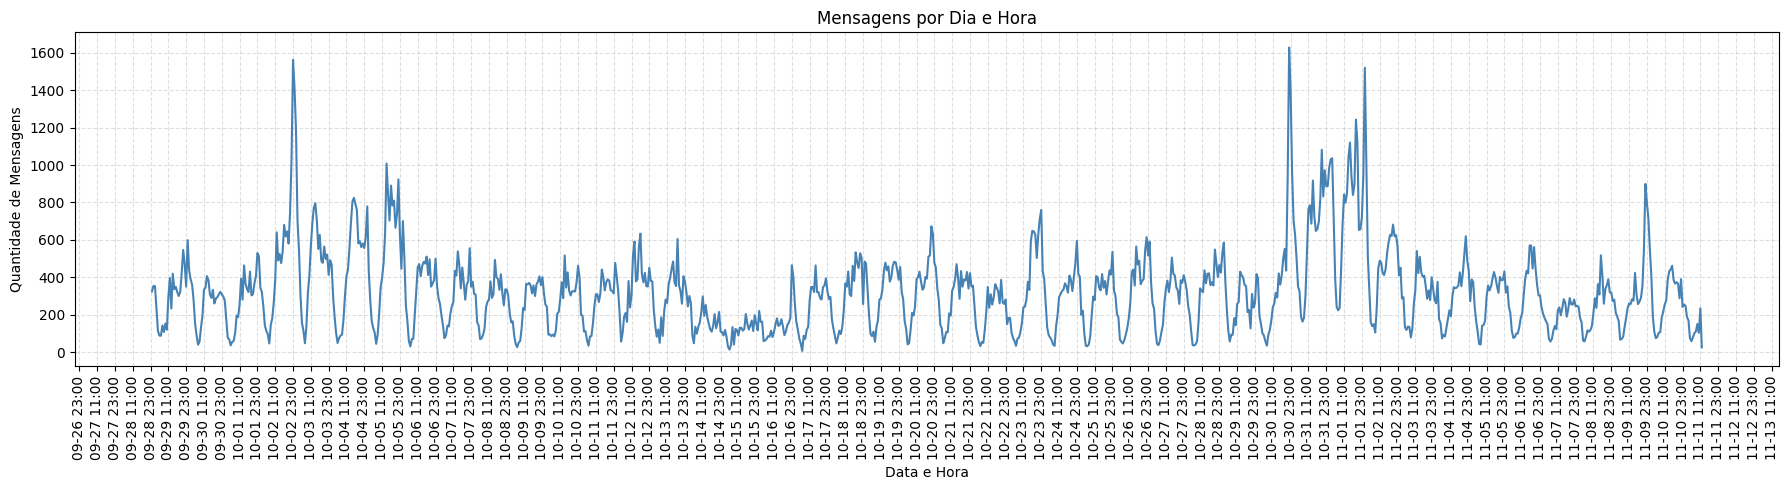

In [74]:
fig, ax = plt.subplots(figsize=(18, 5))

ax.plot(mensagens_por_hora['dia_hora'], mensagens_por_hora['quantidade_mensagens'], color='steelblue')

# Rótulos e grade
ax.set_title('Mensagens por Dia e Hora')
ax.set_xlabel('Data e Hora')
ax.set_ylabel('Quantidade de Mensagens')
ax.grid(True, linestyle='--', alpha=0.4)

ax.xaxis.set_major_locator(mdates.HourLocator(interval=12)) 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

30. Quantidade de mensagens por hora;

In [75]:
df['hora'] = df['date_message'].dt.hour

media_por_hora = (
    df[df['hora'].notna()]
    .groupby('hora')
    .size()
    .reset_index(name='total_mensagens')
)

# Calcular média por hora (dividindo pelo número de dias distintos)
n_dias = df['date_message'].dt.date.nunique()
media_por_hora['media_por_hora'] = media_por_hora['total_mensagens'] / n_dias

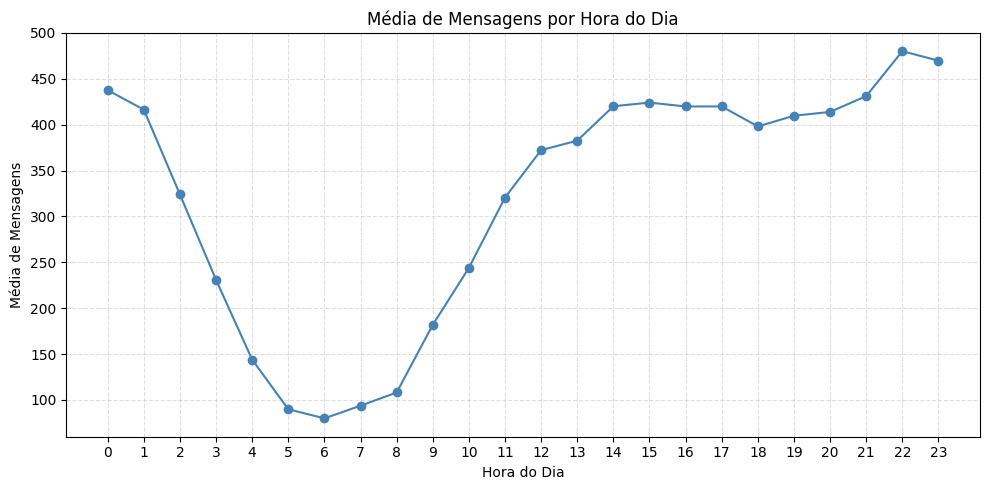

In [76]:
plt.figure(figsize=(10, 5))
plt.plot(media_por_hora['hora'], media_por_hora['media_por_hora'], marker='o', color='steelblue')
plt.xticks(range(0, 24))
plt.title('Média de Mensagens por Hora do Dia')
plt.xlabel('Hora do Dia')
plt.ylabel('Média de Mensagens')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

31. A nuvem de palavras referente às mensagens de texto (após a remoção de stop words);

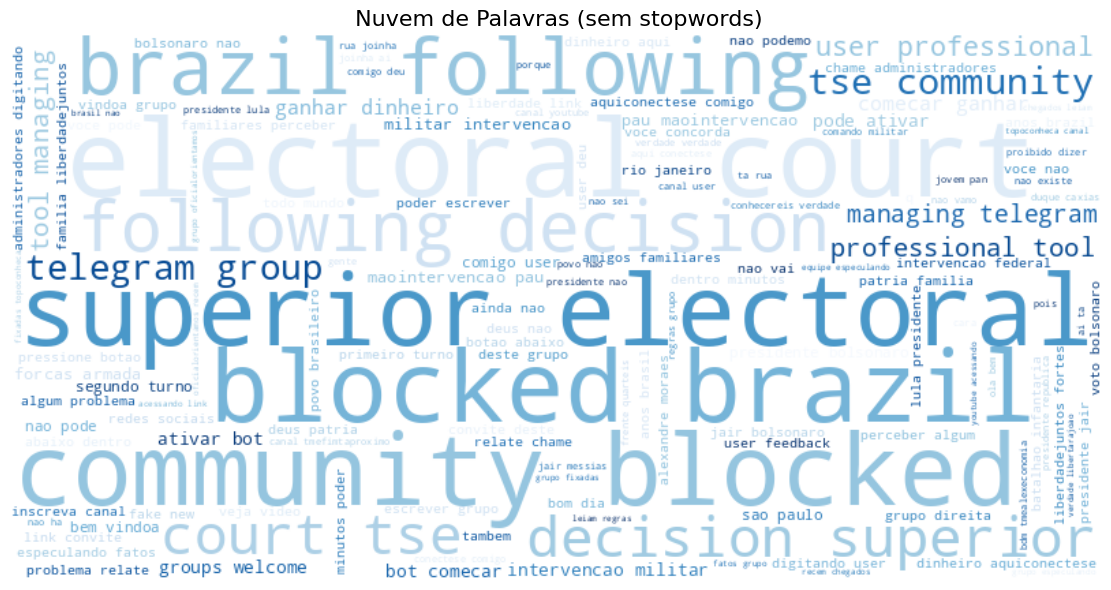

In [ ]:
df_textos = df[df['text_content_anonymous'].notna()].copy()
df_textos['normalized'] = df_textos['text_content_anonymous'].apply(normalize_text)

all_words = []
for linha in df_textos['normalized']:
 
    all_words.exte   tokens = [t for t in linha.split() if t not in stop_words]nd(tokens)

texto_final = ' '.join(all_words)

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Blues').generate(texto_final)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title(' Nuvem de Palavras (sem stopwords)', fontsize=16)
plt.tight_layout()
plt.show()

32. A rede interativa das palavras referente às mensagens de texto (após a remoção de stop words);

In [87]:
df_textos = df[df['text_content_anonymous'].notna()].copy()
df_textos['normalized'] = df_textos['text_content_anonymous'].apply(normalize_text)

# bigramas com stopwords removidas
bigramas = []

for texto in df_textos['normalized']:
    tokens = [t for t in texto.split() if t not in stop_words]
    bigramas.extend(list(ngrams(tokens, 2)))

top_bigramas = Counter(bigramas).most_common(500)  # limite para manter o grafo leve

In [89]:
G = nx.Graph()
for (w1, w2), peso in top_bigramas:
    G.add_edge(w1, w2, weight=peso, value=peso, title=f"{w1} ↔ {w2} ({peso})")

net = Network(height="700px", width="1000px", bgcolor="white", font_color="black")
net.from_nx(G)

# ajuste largura das arestas com base no 'value'
for edge in net.edges:
    edge['width'] = edge['value']  # peso visual da conexão

# ajuste no tamanho dos nós com base no grau
for node in net.nodes:
    grau = G.degree(node['id'])
    node['size'] = 10 + grau * 2

# repulsão
net.repulsion(
    node_distance=200,
    central_gravity=0.1,
    spring_length=150,
    spring_strength=0.05,
    damping=0.09
)

net.write_html("grafo_palavras.html", open_browser=True)


33. Proporção de mensagens com e sem URL;

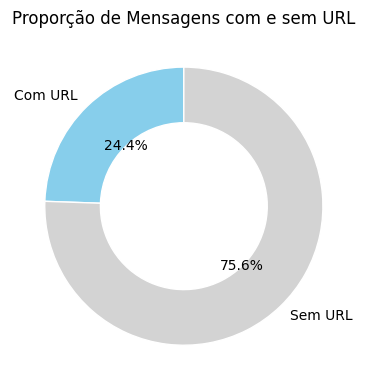

In [92]:
df_filtrado = df[df['text_content_anonymous'].notna()]

contagem = df_filtrado['has_media_url'].value_counts()
labels = ['Com URL', 'Sem URL']
valores = [contagem.get(True, 0), contagem.get(False, 0)]

plt.figure(figsize=(4, 4))
plt.pie(
    valores,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=['skyblue', 'lightgray'],
    wedgeprops={'width': 0.4, 'edgecolor': 'white'}
)
plt.title('Proporção de Mensagens com e sem URL')
plt.tight_layout()
plt.show()

34. Proporção de desinformação;

In [95]:
df['score_misinformation'].describe()

count    167224.000000
mean          0.312263
std           0.293703
min           0.000003
25%           0.078466
50%           0.197592
75%           0.490396
max           1.000000
Name: score_misinformation, dtype: float64

In [96]:
df_valid = df[df['score_misinformation'].notna()].copy()

def classificar_misinformacao(score):
    if score <= 0.3:
        return 'Não Desinformação'
    elif score >= 0.7:
        return 'Desinformação'
    else:
        return 'Neutro'

df_valid['categoria_misinformacao'] = df_valid['score_misinformation'].apply(classificar_misinformacao)

contagem = df_valid['categoria_misinformacao'].value_counts().reindex(['Não Desinformação', 'Neutro', 'Desinformação'], fill_value=0)
valores = contagem.values
labels = contagem.index.tolist()

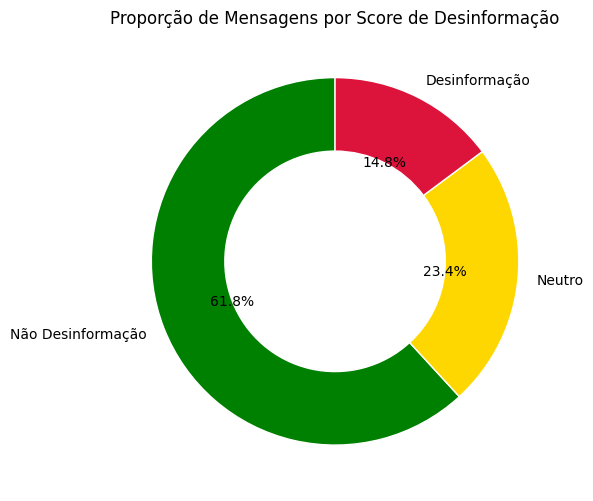

In [ ]:
plt.figure(figsize=(6, 6))
plt.pie(
    valores,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=['green', 'gold', 'crimson'],
    wedgeprops={'width': 0.4, 'edgecolor': 'white'}
)
plt.title('Proporção de Mensagens por Score de Desinformação')
plt.tight_layout()
plt.show()

35. Proporção de mensagens contendo mídia e desinformação;

In [109]:
df_desinfo = df[df['score_misinformation'] >= 0.7].copy()

contagem = df_desinfo['has_media'].value_counts()
labels = ['Com Mídia', 'Sem Mídia']
valores = [contagem.get(True, 0), contagem.get(False, 0)]

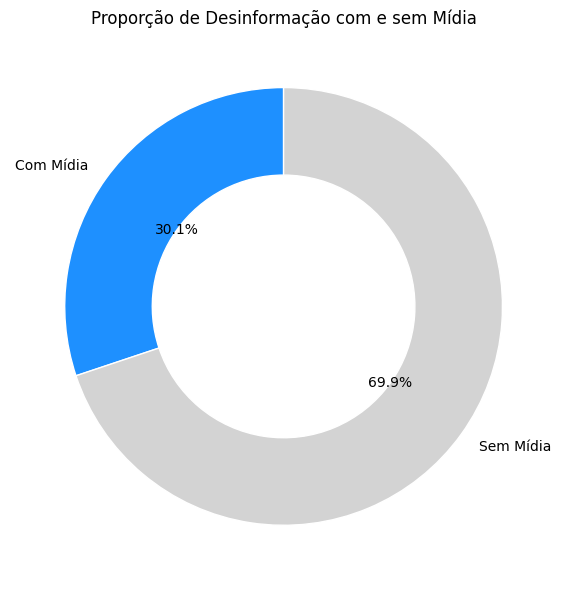

In [111]:
plt.figure(figsize=(6, 6))
plt.pie(
    valores,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=['dodgerblue', 'lightgray'],
    wedgeprops={'width': 0.4, 'edgecolor': 'white'}
)
plt.title('Proporção de Desinformação com e sem Mídia')
plt.tight_layout()
plt.show()

36. Distribuição de mensagens por score de desinformação;

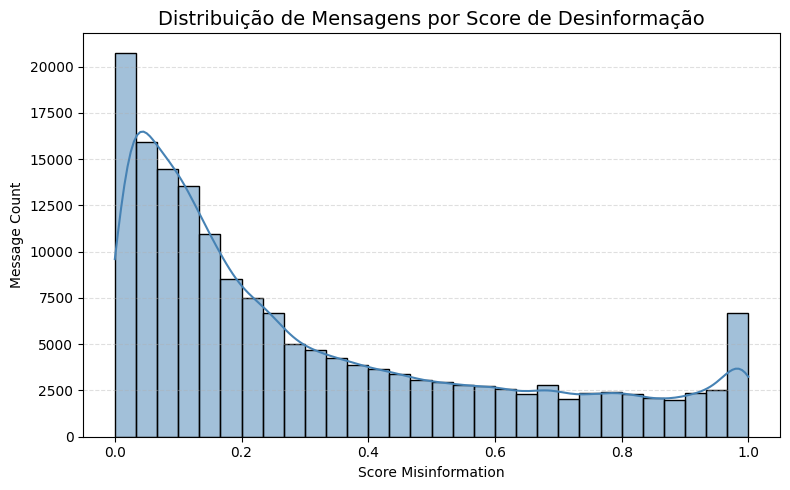

In [114]:
df_valid = df[df['score_misinformation'].notna()].copy()

plt.figure(figsize=(8, 5))
sns.histplot(df_valid['score_misinformation'], bins=30, kde=True, color='steelblue')

plt.title('Distribuição de Mensagens por Score de Desinformação', fontsize=14)
plt.xlabel('Score Misinformation')
plt.ylabel('Message Count')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

37. Proporção de sentimentos;

In [117]:
df['score_sentiment'].describe()

count    339239.000000
mean          0.022025
std           0.529724
min          -1.000000
25%          -0.381800
50%           0.000000
75%           0.505300
max           0.999200
Name: score_sentiment, dtype: float64

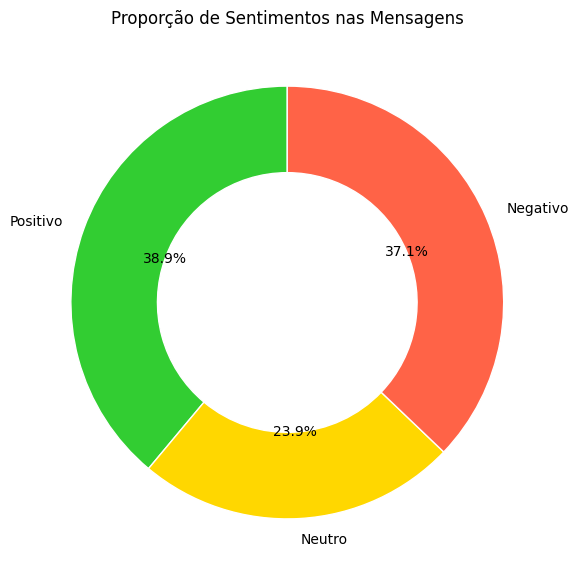

In [ ]:
df_sent = df[df['score_sentiment'].notna()].copy()

def classificar_sentimento(score):
    if score <= -0.05:
        return 'Negativo'
    elif score >= 0.05:
        return 'Positivo'
    else:
        return 'Neutro'

df_sent['categoria_sentimento'] = df_sent['score_sentiment'].apply(classificar_sentimento)

contagem = df_sent['categoria_sentimento'].value_counts().reindex(['Positivo', 'Neutro', 'Negativo'], fill_value=0)
labels = contagem.index
valores = contagem.values

plt.figure(figsize=(6, 6))
plt.pie(
    valores,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=['limegreen', 'gold', 'tomato'],
    wedgeprops={'width': 0.4, 'edgecolor': 'white'}
)
plt.title('Proporção de Sentimentos nas Mensagens')
plt.tight_layout()
plt.show()

38. Distribuição de mensagens por score de sentimentos;

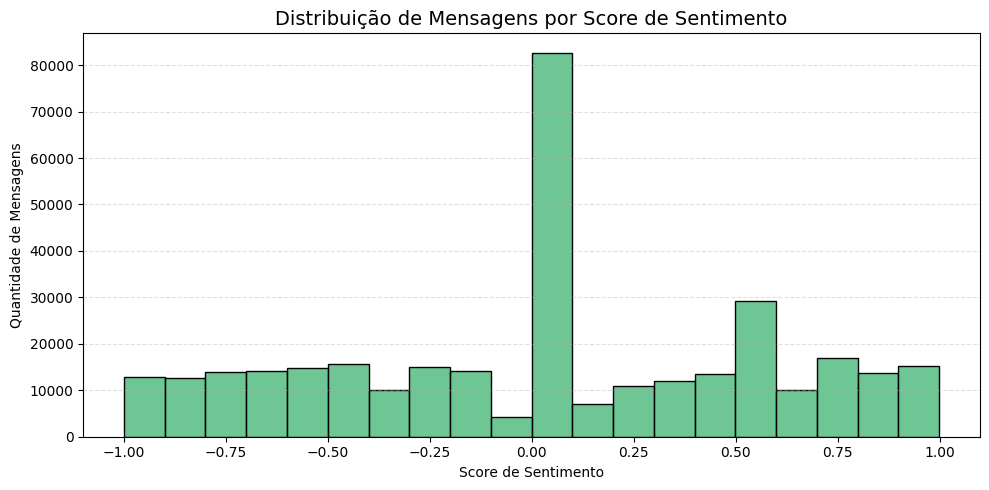

In [121]:
df_valid = df[df['score_sentiment'].notna()].copy()

plt.figure(figsize=(10, 5))
sns.histplot(df_valid['score_sentiment'], bins=20, kde=False, color='mediumseagreen')

plt.title('Distribuição de Mensagens por Score de Sentimento', fontsize=14)
plt.xlabel('Score de Sentimento')
plt.ylabel('Quantidade de Mensagens')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

39. Proporção entre mensagens virais e não virais;

In [127]:
df['normalized_text'] = df['text_content_anonymous'].apply(normalize_text)
df['viral'] = df.duplicated(subset='normalized_text', keep=False).astype(int)

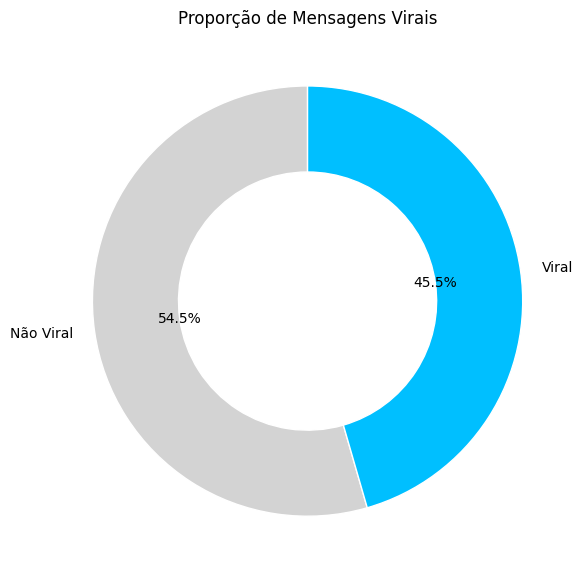

In [129]:
# Contar virais vs não virais
contagem = df['viral'].value_counts().rename(index={0: 'Não Viral', 1: 'Viral'})
labels = contagem.index
valores = contagem.values

# Gráfico
plt.figure(figsize=(6, 6))
plt.pie(
    valores,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=['lightgray', 'deepskyblue'],
    wedgeprops={'width': 0.4, 'edgecolor': 'white'}
)
plt.title('Proporção de Mensagens Virais')
plt.tight_layout()
plt.show()


40. Algo que você julga importante e que ainda não foi solicitado;

In [134]:
df_links = df[df['id_member_anonymous'].notna()][['id_member_anonymous', 'id_group_anonymous']].drop_duplicates()

# Contar quantos grupos cada usuário está
usuarios_multigrupo = df['id_member_anonymous'].value_counts()
usuarios_validos = usuarios_multigrupo[usuarios_multigrupo >= 2].index

# Contar quantos usuários cada grupo tem
grupos_comuns = df['id_group_anonymous'].value_counts()
grupos_validos = grupos_comuns[grupos_comuns <= 100].index

# Filtrar
df_links = df[
    df['id_member_anonymous'].isin(usuarios_validos) &
    df['id_group_anonymous'].isin(grupos_validos)
][['id_member_anonymous', 'id_group_anonymous']].drop_duplicates()


In [ ]:
G = nx.Graph()

# Adicionar nós com tipo
usuarios = df_links['id_member_anonymous'].unique()
grupos = df_links['id_group_anonymous'].unique()

G.add_nodes_from(usuarios, tipo='usuario')
G.add_nodes_from(grupos, tipo='grupo')

# Adicionar arestas (usuário → grupo)
for _, row in df_links.iterrows():
    G.add_edge(row['id_member_anonymous'], row['id_group_anonymous'])

# Criar rede interativa com pyvis
net = Network(height="800px", width="100%", bgcolor="white", font_color="black", notebook=False)
net.from_nx(G)

# Estilizar nós
for node in net.nodes:
    tipo = G.nodes[node['id']].get('tipo')
    if tipo == 'usuario':
        node['color'] = 'lightblue'
        node['shape'] = 'dot'
        node['size'] = 10
    elif tipo == 'grupo':
        node['color'] = 'lightgreen'
        node['shape'] = 'triangle'
        node['size'] = 20

net.repulsion(node_distance=180, spring_length=100)

net.write_html("grafo_usuarios_grupos.html", open_browser=True)

In [138]:
df.to_csv('data_results/df_final_lista-3.csv')